<a href="https://colab.research.google.com/github/hassaku12/manabiDX2025/blob/main/CM_Stitch_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# テーマ3_“売れる相手”は誰だ？ - 金融業のAIマーケティング体験　サンプルコード(CM_Stitchカスタム)


本ノートブックは、**テーマ3：演習03**においてモデル開発するサンプルコードを
* 全てのCSVを利用
* 予測モデルを変更可能に変更
* 手元でできる簡易的な予測精度確認を実装

となるように書き換えたベースラインコードです。<br>


本ノートブックは、以下の流れで構成されています。

* [第1章：分析環境の準備](#1)
* [第2章：データの理解と確認](#2)
* [第3章：データの前処理](#3)
* [第4章：予測モデルの構築と学習](#4)
* [第5章：予測結果の出力](#5)
* [第6章：さらなる精度向上に向けて](#6)

本ノートブックで使用するデータは以下です。

- train.csv
- test.csv
- sample_submit.csv
- 商品リスト.csv
- 適合性判定シート一覧表.csv
- 約定データ一覧表.csv
- 月次保有明細ファイル

データはSignate Cloudのサイトからダウンロードして本ノートブックと同じディレクトリに配置してください。なお、以下のようなフォルダ構成を前提としています。

```
MDXQ（Google Drive の『マイドライブ』直下に MDXQ フォルダを配置してください）
└─ theme3_sample_code.ipynb（本notebook）
└─ train.csv
└─ test.csv
└─ sample_submit.csv
└─ 商品リスト.csv
└─ 適合性判定シート一覧表.csv
└─ 約定データ一覧表.csv
└─ 月次保有明細
   └─ yyyy-mm保有明細.csv (計93ファイル)
```

<a name="1"></a>
# 第1章：分析環境の準備
AIモデルを構築する最初のステップとして、分析作業を行うための環境を整え、必要なツールやデータを準備します。

## 1-1. 実行環境とGoogleドライブのマウント (Google Colaboratoryを利用する場合)



In [162]:
# Google Driveをマウントする場合に実行します (Google Colaboratory環境など)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1-2. 必要なライブラリの導入

In [163]:
# japanize-matplotlib, LightAutoML, gensim, xgboostのインストール (実行環境に未導入の場合)
!pip install japanize-matplotlib lightautoml gensim xgboost

In [164]:
# OSに依存する機能（ファイルパスの操作など）を利用するためのライブラリ
import os
import re
import glob

# データ分析を効率的に行うための高機能なデータ構造（DataFrameなど）を提供するライブラリ
import pandas as pd  # pdという別名で利用するのが慣例です

# 数値計算、特に配列や行列の操作を効率的に行うためのライブラリ
import numpy as np   # npという別名で利用するのが慣例です

# データをグラフとして可視化するためのライブラリ
import matplotlib.pyplot as plt # pltという別名で利用するのが慣例です
import japanize_matplotlib      # matplotlibの日本語表示を自動で設定
import seaborn as sns           # より美しいグラフを簡単に作成できるライブラリ

# LightGBM：高速で高精度な勾配ブースティング機械学習ライブラリ
import lightgbm as lgb          # lgbという別名で利用するのが慣例です

# 機械学習のための包括的なライブラリ (scikit-learn、略してsklearn)
from sklearn.model_selection import KFold, StratifiedKFold  # クロスバリデーション用のデータ分割機能
from sklearn.tree import DecisionTreeClassifier # 決定木分類モデル
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss  # モデル評価指標
from sklearn.preprocessing import LabelEncoder, OneHotEncoder   # カテゴリ変数の数値変換（必要に応じて）

# ===== 追加で利用可能とするモデルをまとめてインポート =====
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.tree import plot_tree

pd.set_option('display.max_columns', None)  # 列方向の表示を省略無しにする

## 1-3. データ格納場所（ファイルパス）の設定

以下のセルで、`base_dir` 変数に適切なパス文字列を代入してください。
**ご自身の環境に合わせて `base_dir` の値を編集してください。**

In [165]:
# --- ご自身の環境に合わせて、以下のいずれかの行のコメントアウトを外し、パスを適切に設定してください ---

# Google ColabでMyDrive直下にMDXQフォルダがあり、その中に配布データを置いた場合の例
base_dir = '/content/drive/MyDrive/Colab Notebooks/マナビDX/'

<a name="2"></a>
# 第2章：データの読み込みと概要把握

第1章で分析環境の準備が整いましたので、次はいよいよ分析対象となるデータをプログラムに読み込み、どのような情報が含まれているかを確認していきます。

## 2-1. 分析用データの読み込み

In [166]:
# 学習用データ
train_df = pd.read_csv(base_dir + 'train.csv')

# 評価用データ
test_df = pd.read_csv(base_dir + 'test.csv')

# 提出ファイル形式見本
submission_df = pd.read_csv(base_dir + 'sample_submit.csv', header=None) # 提出ファイルの形式がヘッダーなしのためヘッダーを読み込まない設定にしている

# 商品リスト
product_df = pd.read_csv(base_dir + '商品リスト.csv')

# 顧客の属性や投資経験に関するデータ
assessment_df = pd.read_csv(base_dir + '適合性判定シート一覧表.csv')

# 約定データ一覧表
execution_df = pd.read_csv(base_dir + '約定データ一覧表.csv')

# 月次保有明細（93ファイルを結合）
monthly_files = sorted(glob.glob(base_dir + '月次保有明細/*保有明細.csv'))
monthly_holdings_df = pd.concat([pd.read_csv(fp) for fp in monthly_files], ignore_index=True)


## 2-2. 読み込んだデータの確認

データが正しく読み込めたか、またどのようなデータが含まれているかを確認するために、表示してみましょう。

In [167]:
# 学習用データ (train_df)
print(train_df.shape)
train_df.head()

(90000, 20)


,ID,顧客ID,住所コード,顧客氏名,基準年月,取得価額,時価価額,評価損益,投資方針,train_term_1,train_term_2,train_term_3,train_term_4,train_term_5,train_term_6,翌月_購入,翌月_売却,翌々月_購入,翌々月_売却,y
0,10001,1,A-1,平野勇,2015-05,235.0,441.15,206.15,2,1,1,1,1,1,1,0,0,0,0,0
1,10002,2,A-1,栗原直人,2015-05,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0
2,10003,3,A-1,川口結衣,2015-05,535.0,540.24,5.24,2,1,1,1,1,1,1,0,0,0,0,0
3,10004,4,A-1,森真希,2015-05,713.0,899.86,186.85,3,1,1,1,1,1,1,0,0,0,0,0
4,10005,5,A-1,後藤歩,2015-05,48.0,48.14,0.14,1,1,1,1,1,1,1,0,0,0,0,0


In [168]:
# 評価用データ (test_df) の先頭5行
print(test_df.shape)
test_df.head()

(6000, 16)


,Unnamed: 0,ID,顧客ID,住所コード,顧客氏名,基準年月,取得価額,時価価額,評価損益,投資方針,test_term_1,test_term_2,test_term_3,test_term_4,test_term_5,test_term_6
0,82000,830001,1,A-1,平野勇,2022-03,0.0,0.00,0.00,2,1,0,0,0,0,0
1,82001,830002,2,A-1,栗原直人,2022-03,0.0,0.00,0.00,2,1,0,0,0,0,0
2,82002,830003,3,A-1,川口結衣,2022-03,768.0,795.58,27.58,2,1,0,0,0,0,0
3,82003,830004,4,A-1,森真希,2022-03,1259.0,1593.91,334.91,3,1,0,0,0,0,0
4,82004,830005,5,A-1,後藤歩,2022-03,103.0,102.06,-0.94,1,1,0,0,0,0,0


In [169]:
# テキストにも記載がない 'Unnamed: 0' 列は削除しておく
test_df = test_df.drop('Unnamed: 0', axis=1)

In [170]:
# 商品リスト
print(product_df.shape)
product_df.head()

(786, 18)


,商品名,商品カテゴリ,リスクカテゴリ,通貨,勧誘留意商品,解約手数料率,発行日,償還日,利率,発行日株価,早期償還株価,ノックイン株価,早期償還日,ノックイン日,契約年月,予定利率,ターゲット,ターゲット到達日
0,Global_Stock_Index_fund,Fund_global_stocks,Global_stocks\r\nCurrency,JPY,1,0.0005,NaN,NaN,-,-,-,-,NaN,NaN,-,-,-,-
1,Japanese_stocks_fund,Fund_japanese_stocks,Japanese_stocks,JPY,1,0.0005,NaN,NaN,-,-,-,-,NaN,NaN,-,-,-,-
2,US_High_Yield_fund,FUnd_US_High_Yield,Global_credit\r\nGlobal_yield\r\nCurrency,JPY,1,0.0005,NaN,NaN,-,-,-,-,NaN,NaN,-,-,-,-
3,US_REIT_fund,Fund_US_REIT,Global_reit\r\nCurrency,JPY,1,0.0005,NaN,NaN,-,-,-,-,NaN,NaN,-,-,-,-
4,Balance_fund,Fund_Balance,Multi,JPY,1,0.0005,NaN,NaN,-,-,-,-,NaN,NaN,-,-,-,-


In [171]:
# Uniqueデータを見ておく
print("商品名", product_df['商品名'].nunique())
print("商品カテゴリ", product_df['商品カテゴリ'].nunique(),product_df['商品カテゴリ'].unique())
print("リスクカテゴリ", product_df['リスクカテゴリ'].nunique(), product_df['リスクカテゴリ'].unique())
print("通貨", product_df['通貨'].unique())
print("勧誘留意商品", product_df['勧誘留意商品'].unique())
print("解約手数料率", product_df['解約手数料率'].unique())
print("利率", product_df['利率'].nunique())
print("発行日株価", product_df['発行日株価'].nunique())
print("早期償還株価", product_df['早期償還株価'].nunique())
print("ノックイン株価", product_df['ノックイン株価'].nunique())
print("予定利率", product_df['予定利率'].nunique())
print("ターゲット", product_df['ターゲット'].nunique())

商品名 786
商品カテゴリ 11 ['Fund_global_stocks' 'Fund_japanese_stocks' 'FUnd_US_High_Yield'
 'Fund_US_REIT' 'Fund_Balance' 'Japanese_bond' 'Global_bond'
 'Structured_bond' 'Spi' 'Foreign_currency_spi'
 'Foreign currency deposits']
リスクカテゴリ 8 ['Global_stocks\r\nCurrency' 'Japanese_stocks'
 'Global_credit\r\nGlobal_yield\r\nCurrency' 'Global_reit\r\nCurrency'
 'Multi' 'JPY_yield' 'Global_yield\r\nCurrency' 'Currency']
通貨 ['JPY' 'USD' 'AUD']
勧誘留意商品 [1 0]
解約手数料率 [0.0005 0.     0.001  0.005 ]
利率 95
発行日株価 155
早期償還株価 155
ノックイン株価 154
予定利率 50
ターゲット 304


In [172]:
# 適合性判定シート一覧表 (assessment_df) の先頭5行
print(assessment_df.shape)
assessment_df.head()

(10383, 22)


,取引日,顧客ID,顧客年齢,投資経験（投資信託）,投資経験（国内債券）,投資経験（外国債券）,投資経験（仕組債）,投資経験（一時払保険）,投資経験（外貨建一時払保険）,投資経験（株式）,投資経験（外国株式）,投資経験（外貨預金）,取引コード,商品名,取得価額,積立投資新規契約,販売員ID,内部管理責任者ID,勧誘記録の具体性,内管の追加説明指示の有無,上司の同席有無,親族の同席有無
0,1991-06-10,687,45,0,1,1,0,1,0,1,0,0,0,US_REIT_fund,286.0,1,1027,2007,5,0,0,0
1,2000-10-10,991,82,1,1,0,1,0,0,1,0,0,0,Japanese_stocks_fund,348.0,1,1040,2010,4,0,1,0
2,2001-08-10,264,73,0,0,0,0,0,0,0,0,0,0,US_REIT_fund,164.0,1,1011,2003,2,1,0,0
3,2003-12-10,267,58,0,1,0,0,0,0,0,0,0,0,US_REIT_fund,406.0,1,1011,2003,3,0,1,0
4,2006-01-10,280,62,0,0,0,0,0,0,0,0,0,0,US_REIT_fund,992.0,1,1011,2003,2,0,0,0


In [173]:
# Uniqueデータを見ておく
print("取引コード", assessment_df['取引コード'].nunique(),assessment_df['取引コード'].unique())
print("商品名", assessment_df['商品名'].nunique())
print("積立投資新規契約", assessment_df['積立投資新規契約'].unique())
print("販売員ID", assessment_df['販売員ID'].nunique())
print("内部管理責任者ID", assessment_df['内部管理責任者ID'].nunique())
print("勧誘記録の具体性", assessment_df['勧誘記録の具体性'].unique())

取引コード 3 [0 1 2]
商品名 673
積立投資新規契約 [1 0]
販売員ID 40
内部管理責任者ID 10
勧誘記録の具体性 [5 4 2 3 1]


In [174]:
# 約定データ一覧表
print(execution_df.shape)
execution_df.head()

(37514, 20)


,取引日,顧客ID,取引コード,商品名,取得価額,取得単価,取引数量,売却単価,売却価額,売却損益,償還価額,償還単価,償還損益,積立投資購入の新規/既存,購入開始年月,購入終了年月,オンライン取引フラグ,ゴール設定実施,ロスカット設定実施,ロスカット水準
0,2015-04-01,269,3,Balance_fund,17.0,NaN,11.63,17209.0,20.01,3.01,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,NaN
1,2015-04-01,671,1,JPY_spi,6.0,100.00,600.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2,2015-04-01,730,3,Global_Stock_Index_fund,5.0,NaN,5.20,22355.0,11.62,6.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
3,2015-04-01,950,1,2015_04_JP,51.0,100.59,5070.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
4,2015-04-01,941,1,2015_04_US,56.0,12021.42,46.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN


In [175]:
# Uniqueデータを見ておく
print("取引コード", execution_df['取引コード'].nunique(),execution_df['取引コード'].unique())
print("商品名", execution_df['商品名'].nunique())
print("積立投資購入の新規/既存", execution_df['積立投資購入の新規/既存'].unique())
print("ロスカット水準", execution_df['ロスカット水準'].unique())

取引コード 5 [3 1 4 2 5]
商品名 636
積立投資購入の新規/既存 [nan 'existing' 'new']
ロスカット水準 [ nan -0.3 -0.2]


In [176]:
# 月次保有明細（93ファイルを結合）
print(monthly_holdings_df.shape)
monthly_holdings_df.head()

(280931, 19)


,顧客ID,住所コード,顧客氏名,取得日,取得価額,通貨,保有数量,基準日,時価価額,評価損益,商品カテゴリ,商品名,積立投資契約フラグ,毎月の購入金額,購入開始日,購入終了日,ゴール設定フラグ,ロスカット設定フラグ,ロスカット水準
0,1,A-1,平野勇,2010-08-26,235.0,JPY,254.16,2015-04-30,441.15,206.15,Fund,Balance_fund,0,0.0,NaN,NaN,0,0,NaN
1,3,A-1,川口結衣,2011-09-28,107.0,JPY,10700.00,2015-04-30,112.24,5.24,Structured_bond,2011_10_NK,0,0.0,NaN,NaN,0,0,NaN
2,3,A-1,川口結衣,2010-08-20,428.0,JPY,42800.00,2015-04-30,428.00,0.00,Spi,JPY_spi,0,0.0,NaN,NaN,0,0,NaN
3,4,A-1,森真希,2010-10-13,143.0,JPY,163.00,2015-04-30,295.94,152.94,Fund,Japanese_stocks_fund,0,0.0,NaN,NaN,0,0,NaN
4,4,A-1,森真希,2010-12-28,570.0,JPY,57000.00,2015-04-30,603.92,33.91,Structured_bond,2011_01_NK,0,0.0,NaN,NaN,0,0,NaN


In [177]:
# Uniqueデータを見ておく
print("住所コード", monthly_holdings_df['住所コード'].nunique())
print("通貨", monthly_holdings_df['通貨'].unique())
print("商品カテゴリ", monthly_holdings_df['商品カテゴリ'].nunique(),monthly_holdings_df['商品カテゴリ'].unique())
print("商品名", monthly_holdings_df['商品名'].nunique())
print("ロスカット水準", monthly_holdings_df['ロスカット水準'].unique())

住所コード 40
通貨 ['JPY' 'USD' 'AUD']
商品カテゴリ 10 ['Fund' 'Structured_bond' 'Spi' 'JP_bond' 'Foreign_depo' 'Global_bond'
 'Foreign_spi' 'Japanese_bond' 'Foreign_currency_spi'
 'Foreign currency deposits']
商品名 670
ロスカット水準 [ nan -0.3 -0.2]


**重要**  
今回のコンペでは予測期間が6つに分かれています。各予測期間で用いる学習用データと評価用データの期間が指定されており、それが `train_term_1` や `test_term_1` のようなフラグ列（値として0か1が入っている列）で示されています。

例えば予測期間1のモデルを作成するために用いる学習用データは
`train_df` の `train_term_1` 列に `1` が入っているデータのみで、  
予測を行うために用いる評価用データは
`test_df` の `test_term_1` 列に `1` が入っているデータのみです。

各予測期間に用いることができるデータの数が、`train_df` `test_df` それぞれ何個あるのかを確認しておきましょう。

In [178]:
# 各予測期間におけるtrain_dfとtest_dfのデータ数を集計
train_counts = train_df[['train_term_1', 'train_term_2', 'train_term_3', 'train_term_4', 'train_term_5', 'train_term_6']].sum()
test_counts = test_df[['test_term_1', 'test_term_2', 'test_term_3', 'test_term_4', 'test_term_5', 'test_term_6']].sum()

# 結果をDataFrameにまとめる
summary_df = pd.DataFrame({
    'train_df': train_counts.values,
    'test_df': test_counts.values
}, index=[f'予測期間_{i}' for i in range(1, 7)])

summary_df

,train_df,test_df
予測期間_1,80000,1000
予測期間_2,82000,1000
予測期間_3,84000,1000
予測期間_4,86000,1000
予測期間_5,88000,1000
予測期間_6,90000,1000


`test_df` に含まれる予測対象データ数は6つの予測期間すべて同じ1000件（顧客1000人分）であることが確認できます。  
モデルの学習に用いることができるデータ数は、例えば  
予測期間1では `80000` 件のデータを学習して `1000` 件の予測を行う、  
予測期間2では `82000` 件のデータを学習して `1000` 件の予測を行う、  
予測期間6では `90000` 件のデータを学習して `1000` 件の予測を行う、  
のように予測期間が後ろになるにつれて学習に使えるデータも増えていることが分かります。

## 2-3. データ全体の情報の確認（要約情報）

次に、各DataFrameのより詳細な情報を確認します。<br>

In [179]:
# 学習用データ (train_df) の情報
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            90000 non-null  int64  
 1   顧客ID          90000 non-null  int64  
 2   住所コード         90000 non-null  object 
 3   顧客氏名          90000 non-null  object 
 4   基準年月          90000 non-null  object 
 5   取得価額          90000 non-null  float64
 6   時価価額          90000 non-null  float64
 7   評価損益          90000 non-null  float64
 8   投資方針          90000 non-null  int64  
 9   train_term_1  90000 non-null  int64  
 10  train_term_2  90000 non-null  int64  
 11  train_term_3  90000 non-null  int64  
 12  train_term_4  90000 non-null  int64  
 13  train_term_5  90000 non-null  int64  
 14  train_term_6  90000 non-null  int64  
 15  翌月_購入         90000 non-null  int64  
 16  翌月_売却         90000 non-null  int64  
 17  翌々月_購入        90000 non-null  int64  
 18  翌々月_売却        90000 non-nu

In [180]:
# 評価用データ (test_df) の情報
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           6000 non-null   int64  
 1   顧客ID         6000 non-null   int64  
 2   住所コード        6000 non-null   object 
 3   顧客氏名         6000 non-null   object 
 4   基準年月         6000 non-null   object 
 5   取得価額         6000 non-null   float64
 6   時価価額         6000 non-null   float64
 7   評価損益         6000 non-null   float64
 8   投資方針         6000 non-null   int64  
 9   test_term_1  6000 non-null   int64  
 10  test_term_2  6000 non-null   int64  
 11  test_term_3  6000 non-null   int64  
 12  test_term_4  6000 non-null   int64  
 13  test_term_5  6000 non-null   int64  
 14  test_term_6  6000 non-null   int64  
dtypes: float64(3), int64(9), object(3)
memory usage: 703.3+ KB


In [181]:
# 適合性判定シート一覧表 (assessment_df) の情報
assessment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10383 entries, 0 to 10382
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   取引日             10383 non-null  object 
 1   顧客ID            10383 non-null  int64  
 2   顧客年齢            10383 non-null  int64  
 3   投資経験（投資信託）      10383 non-null  int64  
 4   投資経験（国内債券）      10383 non-null  int64  
 5   投資経験（外国債券）      10383 non-null  int64  
 6   投資経験（仕組債）       10383 non-null  int64  
 7   投資経験（一時払保険）     10383 non-null  int64  
 8   投資経験（外貨建一時払保険）  10383 non-null  int64  
 9   投資経験（株式）        10383 non-null  int64  
 10  投資経験（外国株式）      10383 non-null  int64  
 11  投資経験（外貨預金）      10383 non-null  int64  
 12  取引コード           10383 non-null  int64  
 13  商品名             10383 non-null  object 
 14  取得価額            10383 non-null  float64
 15  積立投資新規契約        10383 non-null  int64  
 16  販売員ID           10383 non-null  int64  
 17  内部管理責任者ID       10383 non-null 

In [182]:
# 商品リスト (product_df) の情報
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   商品名       786 non-null    object 
 1   商品カテゴリ    786 non-null    object 
 2   リスクカテゴリ   786 non-null    object 
 3   通貨        786 non-null    object 
 4   勧誘留意商品    786 non-null    int64  
 5   解約手数料率    786 non-null    float64
 6   発行日       467 non-null    object 
 7   償還日       467 non-null    object 
 8   利率        786 non-null    object 
 9   発行日株価     786 non-null    object 
 10  早期償還株価    786 non-null    object 
 11  ノックイン株価   786 non-null    object 
 12  早期償還日     126 non-null    object 
 13  ノックイン日    4 non-null      object 
 14  契約年月      785 non-null    object 
 15  予定利率      785 non-null    object 
 16  ターゲット     785 non-null    object 
 17  ターゲット到達日  490 non-null    object 
dtypes: float64(1), int64(1), object(16)
memory usage: 110.7+ KB


In [183]:
# 約定データ
execution_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37514 entries, 0 to 37513
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   取引日           37514 non-null  object 
 1   顧客ID          37514 non-null  int64  
 2   取引コード         37514 non-null  int64  
 3   商品名           37514 non-null  object 
 4   取得価額          37411 non-null  float64
 5   取得単価          32258 non-null  float64
 6   取引数量          37411 non-null  float64
 7   売却単価          3089 non-null   float64
 8   売却価額          3089 non-null   float64
 9   売却損益          3089 non-null   float64
 10  償還価額          2064 non-null   float64
 11  償還単価          2064 non-null   float64
 12  償還損益          2064 non-null   float64
 13  積立投資購入の新規/既存  23380 non-null  object 
 14  購入開始年月        23277 non-null  object 
 15  購入終了年月        2183 non-null   object 
 16  オンライン取引フラグ    37514 non-null  int64  
 17  ゴール設定実施       37514 non-null  int64  
 18  ロスカット設定実施     37514 non-nu

In [184]:
# 月次保有明細
monthly_holdings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280931 entries, 0 to 280930
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   顧客ID        280931 non-null  int64  
 1   住所コード       280931 non-null  object 
 2   顧客氏名        280931 non-null  object 
 3   取得日         280931 non-null  object 
 4   取得価額        280931 non-null  float64
 5   通貨          280931 non-null  object 
 6   保有数量        280931 non-null  float64
 7   基準日         280931 non-null  object 
 8   時価価額        280931 non-null  float64
 9   評価損益        280931 non-null  float64
 10  商品カテゴリ      280931 non-null  object 
 11  商品名         280931 non-null  object 
 12  積立投資契約フラグ   280931 non-null  int64  
 13  毎月の購入金額     64412 non-null   float64
 14  購入開始日       23653 non-null   object 
 15  購入終了日       2583 non-null    object 
 16  ゴール設定フラグ    280931 non-null  int64  
 17  ロスカット設定フラグ  280931 non-null  int64  
 18  ロスカット水準     4270 non-null    float64
dtypes:

## 2.4データのマージ（EDAする前にマージしちゃう）
サンプルコードよりも多くの情報扱えるように・・な視点で結合してみる

※使わないなら後で落とせばいいので、まずは多くの視点でEDAできるようにデータを広げてみる

In [185]:
#========================
# 1) 顧客属性データの前処理
#========================

# assessment_df から採用する列を定義（存在するものだけ使う）
# 顧客の年齢と各種金融商品の投資経験を取得
ASSESS_USE_COLS = [
    '顧客年齢',
    '投資経験（投資信託）','投資経験（国内債券）','投資経験（外国債券）',
    '投資経験（仕組債）','投資経験（一時払保険）','投資経験（外貨建一時払保険）',
    '投資経験（株式）','投資経験（外国株式）','投資経験（外貨預金）'
]

def prepare_assessment_snapshot(assessment_df: pd.DataFrame) -> pd.DataFrame:
    """
    顧客属性データ（assessment_df）を時系列マージ用に前処理する関数

    処理内容：
    1. 日付の型変換と欠損値の除去
    2. 必要な列のみを抽出
    3. 顧客IDの型統一
    4. 同一顧客・同一日のデータは最新のものを採用

    Args:
        assessment_df: 顧客属性の生データ

    Returns:
        前処理済みの顧客属性スナップショットデータ
    """
    # データフレームをコピーして元データを保護
    df = assessment_df.copy()

    # 取引日を datetime 型に変換（変換できない値は NaT になる）
    # errors='coerce' により変換エラーを NaT として処理
    df['取引日'] = pd.to_datetime(df['取引日'], errors='coerce')

    # 取引日が欠損（NaT）の行を除去
    df = df.dropna(subset=['取引日'])

    # 必要な列だけを選択
    # 顧客ID、取引日は必須、その他は存在する列のみを採用
    use_cols = ['顧客ID','取引日'] + [c for c in ASSESS_USE_COLS if c in df.columns]
    df = df[use_cols]

    # 顧客IDを数値型に変換し、int64型で統一
    # errors='raise' により変換エラーがあれば例外を発生させる
    df['顧客ID'] = pd.to_numeric(df['顧客ID'], errors='raise').astype('int64')

    # データの整理とクリーニング
    df = df.sort_values(['顧客ID','取引日'], kind='mergesort') \
           .drop_duplicates(['顧客ID','取引日'], keep='last') \
           .sort_values(['顧客ID','取引日'], kind='mergesort') \
           .reset_index(drop=True)

    return df

#========================
# 2) 顧客IDごとの時間整合マージ（フォールバック：確実版）
#========================

def time_aware_merge_per_customer(base_df: pd.DataFrame, snapshot_df: pd.DataFrame) -> pd.DataFrame:
    """
    基準データに対して、各時点で有効な顧客属性をマージする関数
    各基準年月に対して、その時点以前の最新の顧客属性を紐付ける

    処理の特徴：
    - 顧客IDごとに処理することで、異なる顧客のデータが混ざらない
    - merge_asof を使用して時系列的に正しいデータを紐付け
    - _x/_y のサフィックスが付かないようにbyパラメータで顧客IDを指定

    Args:
        base_df: 基準となるデータフレーム（train_df または test_df）
        snapshot_df: 顧客属性のスナップショットデータ

    Returns:
        顧客属性がマージされたデータフレーム
    """
    # 左側のデータ（基準データ）の準備
    left = base_df.copy()

    # 基準年月を datetime 型に変換（YYYY-MM形式）
    left['基準年月'] = pd.to_datetime(left['基準年月'], format='%Y-%m', errors='raise')

    # カットオフ日を設定（前月末日）
    # 例：2024-03 → 2024-02-29 のように、その月の前月末を計算
    left['cutoff'] = left['基準年月'] - pd.offsets.MonthEnd(1)

    # 顧客IDを数値型に統一
    left['顧客ID'] = pd.to_numeric(left['顧客ID'], errors='raise').astype('int64')

    # 右側のデータ（スナップショット）の準備
    right = snapshot_df.copy()
    right['顧客ID'] = pd.to_numeric(right['顧客ID'], errors='raise').astype('int64')

    # 結果を格納するリスト
    out_parts = []

    # 顧客IDごとにグループ化して処理
    # sort=False により元の順序を保持
    for cid, g in left.groupby('顧客ID', sort=False):
        # 現在の顧客IDに対応するスナップショットデータを抽出
        r = right[right['顧客ID'] == cid]

        # スナップショットデータが存在しない場合
        if r.empty:
            # 顧客属性なしでそのまま追加（cutoff列は削除）
            out_parts.append(g.drop(columns=['cutoff']))
            continue

        # 時系列でソート
        g2 = g.sort_values('cutoff', kind='mergesort')    # 基準データをカットオフ日でソート
        r2 = r.sort_values('取引日', kind='mergesort')     # スナップショットを取引日でソート

        # merge_asof による時系列マージ
        # 各カットオフ日に対して、それ以前の最新の顧客属性を紐付ける
        m = pd.merge_asof(
            g2, r2,                              # 左側と右側のデータ
            left_on='cutoff',                    # 左側の時系列キー
            right_on='取引日',                   # 右側の時系列キー
            by='顧客ID',                         # グループキー（これにより_x/_yが付かない）
            direction='backward',                # 過去方向を参照
            allow_exact_matches=True             # 同日のデータも許可
        ).drop(columns=['取引日','cutoff'])      # 不要な列を削除

        out_parts.append(m)

    # 全顧客のデータを結合
    merged = pd.concat(out_parts, ignore_index=True)
    return merged

#========================
# 3) 実行
#========================

# Step 1: 顧客属性データの前処理
# assessment_df から時系列マージ用のスナップショットを作成
assessment_snapshot = prepare_assessment_snapshot(assessment_df)

# Step 2: 訓練データとテストデータに顧客属性をマージ
# 各基準年月時点で有効な顧客属性を紐付ける
train_df = time_aware_merge_per_customer(train_df, assessment_snapshot)
test_df  = time_aware_merge_per_customer(test_df,  assessment_snapshot)

# 結果の確認（最初の5行を表示）
train_df.head()

,ID,顧客ID,住所コード,顧客氏名,基準年月,取得価額,時価価額,評価損益,投資方針,train_term_1,train_term_2,train_term_3,train_term_4,train_term_5,train_term_6,翌月_購入,翌月_売却,翌々月_購入,翌々月_売却,y,顧客年齢,投資経験（投資信託）,投資経験（国内債券）,投資経験（外国債券）,投資経験（仕組債）,投資経験（一時払保険）,投資経験（外貨建一時払保険）,投資経験（株式）,投資経験（外国株式）,投資経験（外貨預金）
0,10001,1,A-1,平野勇,2015-05-01,235.0,441.15,206.15,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20001,1,A-1,平野勇,2015-06-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30001,1,A-1,平野勇,2015-07-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40001,1,A-1,平野勇,2015-08-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50001,1,A-1,平野勇,2015-09-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
# ===============================
# product_df を「最小限」だけ使って execution_df に統合
# ・商品名→商品カテゴリ（存在すれば）だけを利用
# ・複雑なカテゴリ別ワンホットや窓集計はしない
# ・時間軸は既存の merge_exec と同じ（cutoff以前のみ）
# ===============================

#========================
# 商品マスタの前処理
#========================

def prepare_product_map_min(product_df: pd.DataFrame) -> pd.DataFrame:
    """
    商品名→商品カテゴリ、リスクカテゴリのマッピングテーブルを作成
    必要な列が存在しない場合は空文字列で補完する

    Args:
        product_df: 商品マスタデータ

    Returns:
        商品名をキーとした商品属性のマッピングテーブル
    """
    pm = product_df.copy()

    # 必須列が存在しない場合は空文字列で作成
    # これによりデータ不足でもエラーを回避
    if '商品名' not in pm.columns:
        pm['商品名'] = ''
    if '商品カテゴリ' not in pm.columns:
        pm['商品カテゴリ'] = ''
    if 'リスクカテゴリ' not in pm.columns:
        pm['リスクカテゴリ'] = ''

    # 型変換と欠損値処理
    pm['商品名'] = pm['商品名'].astype(str)
    pm['商品カテゴリ'] = pm['商品カテゴリ'].astype(str).fillna('')
    pm['リスクカテゴリ'] = pm['リスクカテゴリ'].astype(str).fillna('')

    # 商品名の重複を除去（最新のレコードを採用）し、必要な列のみ抽出
    pm = pm.drop_duplicates('商品名', keep='last')[['商品名','商品カテゴリ','リスクカテゴリ']]
    return pm

#========================
# 1) 約定明細を「顧客×日付」スナップショット化
#========================

def prepare_exec_snapshot_with_product(execution_df: pd.DataFrame, product_df: pd.DataFrame) -> pd.DataFrame:
    """
    約定明細データを顧客×日付単位で集約し、商品カテゴリ・リスク情報を付与
    各顧客の取引履歴を日次で集計し、累積値も計算する

    主な集計項目：
    - 取引回数、買付回数、売却回数
    - 買付金額、売却・償還金額の累積
    - 商品カテゴリ・リスクカテゴリの多様性

    Args:
        execution_df: 約定明細データ
        product_df: 商品マスタデータ

    Returns:
        顧客×日付で集約されたスナップショットデータ
    """
    df = execution_df.copy()

    # ===== 基本的なデータクレンジング =====
    # 取引日を datetime 型に変換し、変換できない行を除去
    df['取引日'] = pd.to_datetime(df['取引日'], errors='coerce')
    df = df.dropna(subset=['取引日'])

    # 顧客IDを数値型に統一
    df['顧客ID'] = pd.to_numeric(df['顧客ID'], errors='raise').astype('int64')

    # ===== 商品属性の付与 =====
    # 商品マスタから商品カテゴリとリスクカテゴリを取得
    pm = prepare_product_map_min(product_df)
    if '商品名' in df.columns:
        df['商品名'] = df['商品名'].astype(str)
        # 商品名をキーにして商品属性をマージ
        df = df.merge(pm, on='商品名', how='left')

    # 商品カテゴリ・リスクカテゴリが存在しない場合は空文字で補完
    if '商品カテゴリ' not in df.columns:
        df['商品カテゴリ'] = ''
    if 'リスクカテゴリ' not in df.columns:
        df['リスクカテゴリ'] = ''
    df['商品カテゴリ'] = df['商品カテゴリ'].astype(str).fillna('')
    df['リスクカテゴリ'] = df['リスクカテゴリ'].astype(str).fillna('')

    # ===== 取引種別の判定 =====
    # 取引コードから買付・売却を判定
    # 取引コード 1,2: 買付、3: 売却
    code = pd.to_numeric(df.get('取引コード', 0), errors='coerce').fillna(0).astype(int)
    is_buy  = (code.isin([1, 2])).astype(int)  # 買付フラグ（0 or 1）
    is_sell = (code == 3).astype(int)           # 売却フラグ（0 or 1）

    # ===== 金額の処理 =====
    # 各種金額を数値化し、負値は0でクリップ（データ異常対策）
    buy_amt    = pd.to_numeric(df.get('取得価額', 0.0), errors='coerce').fillna(0.0).clip(lower=0.0)
    sell_amt   = pd.to_numeric(df.get('売却価額', 0.0), errors='coerce').fillna(0.0).clip(lower=0.0)
    redeem_amt = pd.to_numeric(df.get('償還価額', 0.0), errors='coerce').fillna(0.0).clip(lower=0.0)

    # ===== 集計用の補助列を作成 =====
    df['_is_buy']   = is_buy                    # 買付フラグ
    df['_is_sell']  = is_sell                   # 売却フラグ
    df['_buy_amt']  = buy_amt                   # 買付金額
    df['_out_amt']  = sell_amt + redeem_amt     # 売却・償還金額の合計

    # 買付があった商品のカテゴリ（買付時のみ値を持つ、それ以外はNaN）
    # nunique計算用：買付した商品カテゴリの種類数を数えるため
    df['_cat_when_buy'] = np.where(is_buy == 1, df['商品カテゴリ'], np.nan)

    # ===== リスクカテゴリの多様性を計算（日毎ユニーク数）=====
    # 買付取引のリスクカテゴリを分析（複数カテゴリが記載されている場合に対応）

    # 買付行のみを抽出
    risk_buy = df.loc[is_buy == 1, ['顧客ID','取引日','リスクカテゴリ']].copy()

    # リスクカテゴリを分割する関数
    # 複数のリスクが「、，,/|;・空白」などで区切られている場合に対応
    def _split_risk(s: str):
        """
        リスクカテゴリ文字列を個別のトークンに分割
        例: "高リスク、中リスク" → ["高リスク", "中リスク"]
        """
        if not isinstance(s, str) or s.strip() == '':
            return []
        # 各種区切り文字を空白に統一してから分割
        return [t for t in re.sub(r'[、，,/|;・\s]+', ' ', s.strip()).split(' ') if t]

    # リスクカテゴリを分割してリスト化
    risk_buy['リスクカテゴリ'] = risk_buy['リスクカテゴリ'].apply(_split_risk)

    # explode: リストの各要素を別行に展開
    # 例: [顧客1, 2024-01-01, ["高リスク", "中リスク"]]
    #  → [顧客1, 2024-01-01, "高リスク"], [顧客1, 2024-01-01, "中リスク"]
    risk_buy = risk_buy.explode('リスクカテゴリ')
    risk_buy = risk_buy.dropna(subset=['リスクカテゴリ'])

    # 顧客×日付でリスクカテゴリのユニーク数を集計
    risk_per_day = (
        risk_buy.groupby(['顧客ID','取引日'])['リスクカテゴリ']
                .nunique()                       # ユニークなリスクカテゴリ数
                .rename('buy_risk_n_day')
                .reset_index()
    )

    # ===== 顧客×日付で取引を集約 =====
    # 同一顧客・同一日の複数取引を1行にまとめる
    daily = (
        df.groupby(['顧客ID','取引日'], as_index=False)
          .agg(
              tx_cnt   = ('_is_buy', 'size'),              # その日の総取引数
              buy_cnt  = ('_is_buy', 'sum'),               # その日の買付回数
              sell_cnt = ('_is_sell','sum'),               # その日の売却回数
              amt_in   = ('_buy_amt','sum'),               # その日の買付金額合計
              amt_out  = ('_out_amt','sum'),               # その日の売却・償還金額合計
              buy_cat_n_day = ('_cat_when_buy', pd.Series.nunique),  # その日に買付した商品カテゴリ数
          )
          .sort_values(['顧客ID','取引日'])
          .reset_index(drop=True)
    )

    # リスクカテゴリの日次ユニーク数をマージ（該当なしは0）
    daily = daily.merge(risk_per_day, on=['顧客ID','取引日'], how='left')
    daily['buy_risk_n_day'] = daily['buy_risk_n_day'].fillna(0)

    # ===== 累積値の計算 =====
    # 各顧客について、その日までの累積取引情報を計算
    g = daily.groupby('顧客ID', group_keys=False)
    daily['cum_tx_cnt']        = g['tx_cnt'].cumsum()         # 累積取引回数
    daily['cum_buy_cnt']       = g['buy_cnt'].cumsum()        # 累積買付回数
    daily['cum_sell_cnt']      = g['sell_cnt'].cumsum()       # 累積売却回数
    daily['cum_amt_in']        = g['amt_in'].cumsum()         # 累積買付金額
    daily['cum_amt_out']       = g['amt_out'].cumsum()        # 累積売却・償還金額
    daily['cum_buy_cat_n_proxy']  = g['buy_cat_n_day'].cumsum()   # 累積商品カテゴリ数（代理指標）
    daily['cum_buy_risk_n_proxy'] = g['buy_risk_n_day'].cumsum()  # 累積リスクカテゴリ数（代理指標）

    # 最終取引日を記録（後で経過日数計算に使用）
    daily['last_tx_date'] = daily['取引日']

    # ===== 必要な列のみを保持 =====
    keep = [
        '顧客ID','取引日','last_tx_date',
        'cum_tx_cnt','cum_buy_cnt','cum_sell_cnt','cum_amt_in','cum_amt_out',
        'buy_cat_n_day','cum_buy_cat_n_proxy',
        'buy_risk_n_day','cum_buy_risk_n_proxy'
    ]
    return daily[keep].sort_values(['顧客ID','取引日']).reset_index(drop=True)

#========================
# 2) 顧客単位の asof マージ（時系列整合性を保った結合）
#========================

def merge_exec(base_df: pd.DataFrame, exec_snap: pd.DataFrame) -> pd.DataFrame:
    """
    基準データに対して、各時点で有効な取引履歴情報をマージ
    各基準年月時点での最新の取引状況を紐付ける

    特徴：
    - 最終取引からの経過日数も計算
    - 取引履歴がない顧客は0で初期化

    Args:
        base_df: 基準となるデータフレーム（train_df または test_df）
        exec_snap: 取引履歴のスナップショットデータ

    Returns:
        取引履歴情報がマージされたデータフレーム
    """
    # ===== 左側データ（基準データ）の準備 =====
    left = base_df.copy()
    left['基準年月'] = pd.to_datetime(left['基準年月'], format='%Y-%m', errors='raise')
    # カットオフ日：基準年月の前月末（この日までの情報を使用）
    left['cutoff']   = left['基準年月'] - pd.offsets.MonthEnd(1)
    left['顧客ID']   = pd.to_numeric(left['顧客ID'], errors='raise').astype('int64')

    # ===== 右側データ（取引スナップショット）の準備 =====
    right = exec_snap.copy()
    right['顧客ID'] = pd.to_numeric(right['顧客ID'], errors='raise').astype('int64')

    # 結果を格納するリスト
    merged_parts = []

    # ===== 顧客ごとに処理 =====
    for cid, g in left.groupby('顧客ID', sort=False):
        # 現在の顧客の取引履歴を抽出
        r = right[right['顧客ID'] == cid]

        # 取引履歴がない顧客の処理
        if r.empty:
            g2 = g.copy()
            # 全ての取引関連指標を0で初期化
            for c in [
                'cum_tx_cnt','cum_buy_cnt','cum_sell_cnt','cum_amt_in','cum_amt_out',
                'buy_cat_n_day','cum_buy_cat_n_proxy',
                'buy_risk_n_day','cum_buy_risk_n_proxy'
            ]:
                g2[c] = 0
            # 最終取引からの経過日数は欠損値
            g2['days_since_last_tx'] = np.nan
            merged_parts.append(g2.drop(columns=['cutoff']))
            continue

        # 時系列でソート
        g2 = g.sort_values('cutoff')      # 基準データをカットオフ日でソート
        r2 = r.sort_values('取引日')      # 取引履歴を取引日でソート

        # ===== merge_asof による時系列マージ =====
        # 各カットオフ日に対して、それ以前の最新の取引情報を紐付け
        m = pd.merge_asof(
            g2, r2,
            left_on='cutoff',              # 左側の時系列キー
            right_on='取引日',             # 右側の時系列キー
            by='顧客ID',                   # グループキー
            direction='backward',           # 過去方向を参照
            allow_exact_matches=True        # 同日のデータも許可
        )

        # ===== 最終取引からの経過日数を計算 =====
        # last_tx_date列があれば優先、なければ取引日を使用
        ref_date = m['last_tx_date'] if 'last_tx_date' in m.columns else m['取引日']
        m['days_since_last_tx'] = (m['cutoff'] - ref_date).dt.days

        # 不要な列を削除
        m = m.drop(columns=[c for c in ['取引日','cutoff'] if c in m.columns])

        # ===== 欠損値の処理 =====
        # 累積値や日次カウントの欠損は0で埋める
        for c in [
            'cum_tx_cnt','cum_buy_cnt','cum_sell_cnt','cum_amt_in','cum_amt_out',
            'buy_cat_n_day','cum_buy_cat_n_proxy',
            'buy_risk_n_day','cum_buy_risk_n_proxy'
        ]:
            if c in m.columns:
                m[c] = m[c].fillna(0)

        merged_parts.append(m)

    # 全顧客のデータを結合
    return pd.concat(merged_parts, ignore_index=True)


# ===== 実行例 =====
# Step 1: 約定明細から取引履歴スナップショットを作成
# 商品マスタの情報も活用して商品カテゴリ・リスク情報を付与
exec_snap = prepare_exec_snapshot_with_product(execution_df, product_df)

# Step 2: 訓練データとテストデータに取引履歴情報をマージ
# 各基準年月時点での累積取引情報と最終取引からの経過日数を付与
train_df  = merge_exec(train_df, exec_snap)
test_df   = merge_exec(test_df,  exec_snap)

# 結果の確認
train_df.head()

,ID,顧客ID,住所コード,顧客氏名,基準年月,取得価額,時価価額,評価損益,投資方針,train_term_1,train_term_2,train_term_3,train_term_4,train_term_5,train_term_6,翌月_購入,翌月_売却,翌々月_購入,翌々月_売却,y,顧客年齢,投資経験（投資信託）,投資経験（国内債券）,投資経験（外国債券）,投資経験（仕組債）,投資経験（一時払保険）,投資経験（外貨建一時払保険）,投資経験（株式）,投資経験（外国株式）,投資経験（外貨預金）,last_tx_date,cum_tx_cnt,cum_buy_cnt,cum_sell_cnt,cum_amt_in,cum_amt_out,buy_cat_n_day,cum_buy_cat_n_proxy,buy_risk_n_day,cum_buy_risk_n_proxy,days_since_last_tx
0,10001,1,A-1,平野勇,2015-05-01,235.0,441.15,206.15,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,NaN
1,20001,1,A-1,平野勇,2015-06-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-27,1.0,0.0,1.0,235.0,448.62,0.0,0.0,0.0,0.0,4.0
2,30001,1,A-1,平野勇,2015-07-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-27,1.0,0.0,1.0,235.0,448.62,0.0,0.0,0.0,0.0,34.0
3,40001,1,A-1,平野勇,2015-08-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-27,1.0,0.0,1.0,235.0,448.62,0.0,0.0,0.0,0.0,65.0
4,50001,1,A-1,平野勇,2015-09-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-27,1.0,0.0,1.0,235.0,448.62,0.0,0.0,0.0,0.0,96.0


In [187]:
#========================
# 1) 月次保有データを「顧客×基準日」スナップショットに要約
#========================

def prepare_holdings_snapshot(monthly_holdings_df: pd.DataFrame) -> pd.DataFrame:
    """
    月次保有データから顧客×基準日単位のスナップショットを作成
    各月末時点での顧客の保有状況（ポートフォリオの状態）を集約

    主な集計項目：
    - 時価総額、評価損益
    - ポジション数（保有銘柄数）
    - 通貨別の時価価額
    - 積立投資の状況

    Args:
        monthly_holdings_df: 月次保有明細データ

    Returns:
        顧客×基準日で集約された保有状況スナップショット
    """
    df = monthly_holdings_df.copy()

    # ===== 日付と顧客IDの型変換・クレンジング =====
    # 基準日をdatetime型に変換（変換できない値はNaTになる）
    df['基準日'] = pd.to_datetime(df['基準日'], errors='coerce')
    # 基準日が欠損している行を除去
    df = df.dropna(subset=['基準日'])
    # 顧客IDを数値型に統一
    df['顧客ID'] = pd.to_numeric(df['顧客ID'], errors='raise').astype('int64')

    # ===== 数値列の安全な処理 =====
    # 時価価額、評価損益、毎月の購入金額を数値化
    # 列が存在しない場合は0で初期化（データ不足への対応）
    for col in ['時価価額','評価損益','毎月の購入金額']:
        if col in df.columns:
            # 数値変換できない値は0に置換
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
        else:
            # 列自体が存在しない場合は0で作成
            df[col] = 0.0

    # ===== 通貨列の標準化処理 =====
    # 通貨情報の有無を確認
    cur_col = '通貨' if '通貨' in df.columns else None
    if cur_col is None:
        # 通貨列が存在しない場合は'UNK'（Unknown）で作成
        df['通貨'] = 'UNK'
        cur_col = '通貨'
    # 欠損値を'UNK'で埋めて文字列型に統一
    df[cur_col] = df[cur_col].fillna('UNK').astype(str)

    # ===== 通貨別時価価額の計算 =====
    # 各通貨（JPY、USD、AUD）ごとの時価価額を個別に集計
    # 該当通貨の場合のみ時価価額を計上、それ以外は0
    df['mv_JPY'] = np.where(df[cur_col] == 'JPY', df['時価価額'], 0.0)  # 日本円建て
    df['mv_USD'] = np.where(df[cur_col] == 'USD', df['時価価額'], 0.0)  # 米ドル建て
    df['mv_AUD'] = np.where(df[cur_col] == 'AUD', df['時価価額'], 0.0)  # 豪ドル建て

    # ===== 積立投資フラグの処理 =====
    # 積立投資契約の有無を確認
    tsum_col = '積立投資契約フラグ' if '積立投資契約フラグ' in df.columns else None
    if tsum_col is None:
        # 積立投資フラグが存在しない場合は0で作成
        df['積立投資契約フラグ'] = 0
        tsum_col = '積立投資契約フラグ'
    # 数値化して整数型に統一（0 or 1）
    df[tsum_col] = pd.to_numeric(df[tsum_col], errors='coerce').fillna(0).astype(int)

    # ===== 顧客×基準日での集約 =====
    # 同一顧客・同一基準日の複数レコードを1行にまとめる
    # その月末時点での顧客のポートフォリオ状態を表現
    snap = (df.groupby(['顧客ID','基準日'], as_index=False)
              .agg(
                  # 時価総額：全保有商品の時価価額合計
                  mv_total=('時価価額','sum'),

                  # 評価損益合計：全保有商品の評価損益合計
                  pl_total=('評価損益','sum'),

                  # ポジション数：保有している商品の種類数
                  n_positions=('顧客ID','size'),

                  # 積立投資フラグ：1つでも積立があれば1（max）
                  tsumitate_flag_any=(tsum_col,'max'),

                  # 積立月額合計：全積立商品の月額購入金額合計
                  tsumitate_monthly_amt=('毎月の購入金額','sum'),

                  # 通貨別時価価額
                  mv_JPY=('mv_JPY','sum'),    # 円建て資産の時価総額
                  mv_USD=('mv_USD','sum'),    # ドル建て資産の時価総額
                  mv_AUD=('mv_AUD','sum')     # 豪ドル建て資産の時価総額
              )
              .sort_values(['顧客ID','基準日'])
              .reset_index(drop=True))

    # ===== 最終保有日の記録 =====
    # asofマージ時の参照用および経過日数計算用
    snap['last_holding_date'] = snap['基準日']

    return snap


#========================
# 2) 顧客単位の asof マージ（時系列整合性を保った結合）
#========================

def merge_holdings(base_df: pd.DataFrame, hold_snap: pd.DataFrame) -> pd.DataFrame:
    """
    基準データに対して、各時点で有効な保有状況をマージ
    各基準年月時点での最新のポートフォリオ状態を紐付ける

    特徴：
    - カットオフ日（前月末）時点の保有状況を取得
    - 最終保有からの経過日数も計算
    - 保有履歴がない顧客は全て0で初期化

    Args:
        base_df: 基準となるデータフレーム（train_df または test_df）
        hold_snap: 保有状況のスナップショットデータ

    Returns:
        保有状況がマージされたデータフレーム
    """
    # ===== 左側データ（基準データ）の準備 =====
    left = base_df.copy()
    # 基準年月をdatetime型に変換
    left['基準年月'] = pd.to_datetime(left['基準年月'], format='%Y-%m', errors='raise')

    # カットオフ日の設定：基準年月の前月末
    # 例：2024-03 → 2024-02-29（未来の情報を使わないため）
    left['cutoff'] = left['基準年月'] - pd.offsets.MonthEnd(1)

    # 顧客IDを数値型に統一
    left['顧客ID'] = pd.to_numeric(left['顧客ID'], errors='raise').astype('int64')

    # ===== 右側データ（保有スナップショット）の準備 =====
    right = hold_snap.copy()
    right['顧客ID'] = pd.to_numeric(right['顧客ID'], errors='raise').astype('int64')

    # 結果を格納するリスト
    merged_parts = []

    # ===== 顧客ごとに処理 =====
    for cid, g in left.groupby('顧客ID', sort=False):
        # 現在の顧客の保有履歴を抽出
        r = right[right['顧客ID'] == cid]

        # ===== 保有履歴がない顧客の処理 =====
        if r.empty:
            g2 = g.copy()

            # 保有関連の状態量は全て0で初期化
            # （取引・保有なし = ポートフォリオが空）
            fill0 = ['mv_total','pl_total','n_positions','tsumitate_flag_any',
                     'tsumitate_monthly_amt','mv_JPY','mv_USD','mv_AUD']
            for c in fill0:
                g2[c] = 0

            # 日付関連は欠損値（NaT、NaN）で初期化
            g2['last_holding_date'] = pd.NaT        # 最終保有日なし
            g2['days_since_last_holding'] = np.nan  # 経過日数計算不可

            merged_parts.append(g2.drop(columns=['cutoff']))
            continue

        # ===== 保有履歴がある顧客の処理 =====
        # 時系列でソート
        g2 = g.sort_values('cutoff')    # 基準データをカットオフ日でソート
        r2 = r.sort_values('基準日')    # 保有データを基準日でソート

        # merge_asof による時系列マージ
        # 各カットオフ日に対して、それ以前の最新の保有状況を紐付け
        m = pd.merge_asof(
            g2, r2,
            left_on='cutoff',           # 左側の時系列キー（カットオフ日）
            right_on='基準日',          # 右側の時系列キー（保有データの基準日）
            by='顧客ID',                # グループキー（顧客ID_x/yの発生を防ぐ）
            direction='backward',        # 過去方向を参照（未来の情報を使わない）
            allow_exact_matches=True     # 同日のデータも許可
        )

        # ===== 最終保有からの経過日数を計算 =====
        # カットオフ日と最終保有日の差分（日数）
        m['days_since_last_holding'] = (m['cutoff'] - m['last_holding_date']).dt.days

        # 不要な列を削除
        m = m.drop(columns=['基準日','cutoff'])

        # ===== 欠損値の処理 =====
        # 保有関連の状態量は欠損を0で埋める
        # （データがない = 保有なし = 0 という解釈が自然）
        for c in ['mv_total','pl_total','n_positions','tsumitate_flag_any',
                  'tsumitate_monthly_amt','mv_JPY','mv_USD','mv_AUD']:
            if c in m.columns:
                m[c] = m[c].fillna(0)

        merged_parts.append(m)

    # 全顧客のデータを結合
    return pd.concat(merged_parts, ignore_index=True)


# ===== 実行例 =====
# Step 1: 月次保有データから保有状況スナップショットを作成
# 各月末時点でのポートフォリオ状態を集約
hold_snap = prepare_holdings_snapshot(monthly_holdings_df)

# Step 2: 訓練データとテストデータに保有状況をマージ
# 各基準年月時点での最新のポートフォリオ状態を紐付け
train_df  = merge_holdings(train_df, hold_snap)
test_df   = merge_holdings(test_df,  hold_snap)

# 結果の確認（最初の5行を表示）
train_df.head()


,ID,顧客ID,住所コード,顧客氏名,基準年月,取得価額,時価価額,評価損益,投資方針,train_term_1,train_term_2,train_term_3,train_term_4,train_term_5,train_term_6,翌月_購入,翌月_売却,翌々月_購入,翌々月_売却,y,顧客年齢,投資経験（投資信託）,投資経験（国内債券）,投資経験（外国債券）,投資経験（仕組債）,投資経験（一時払保険）,投資経験（外貨建一時払保険）,投資経験（株式）,投資経験（外国株式）,投資経験（外貨預金）,last_tx_date,cum_tx_cnt,cum_buy_cnt,cum_sell_cnt,cum_amt_in,cum_amt_out,buy_cat_n_day,cum_buy_cat_n_proxy,buy_risk_n_day,cum_buy_risk_n_proxy,days_since_last_tx,mv_total,pl_total,n_positions,tsumitate_flag_any,tsumitate_monthly_amt,mv_JPY,mv_USD,mv_AUD,last_holding_date,days_since_last_holding
0,10001,1,A-1,平野勇,2015-05-01,235.0,441.15,206.15,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,NaN,441.15,206.15,1.0,0.0,0.0,441.15,0.0,0.0,2015-04-30,0.0
1,20001,1,A-1,平野勇,2015-06-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-27,1.0,0.0,1.0,235.0,448.62,0.0,0.0,0.0,0.0,4.0,441.15,206.15,1.0,0.0,0.0,441.15,0.0,0.0,2015-04-30,31.0
2,30001,1,A-1,平野勇,2015-07-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-27,1.0,0.0,1.0,235.0,448.62,0.0,0.0,0.0,0.0,34.0,441.15,206.15,1.0,0.0,0.0,441.15,0.0,0.0,2015-04-30,61.0
3,40001,1,A-1,平野勇,2015-08-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-27,1.0,0.0,1.0,235.0,448.62,0.0,0.0,0.0,0.0,65.0,441.15,206.15,1.0,0.0,0.0,441.15,0.0,0.0,2015-04-30,92.0
4,50001,1,A-1,平野勇,2015-09-01,0.0,0.00,0.00,2,1,1,1,1,1,1,0,0,0,0,0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-27,1.0,0.0,1.0,235.0,448.62,0.0,0.0,0.0,0.0,96.0,441.15,206.15,1.0,0.0,0.0,441.15,0.0,0.0,2015-04-30,123.0


## 2-5. データの探索（EDA）- もう少し詳しく見てみよう
`.head() `や `.info()` でデータの基本的な構造は掴めましたが、もう少しデータの中身について深掘りしてみましょう。これを探索的データ分析（EDA: Exploratory Data Analysis）と呼びます。

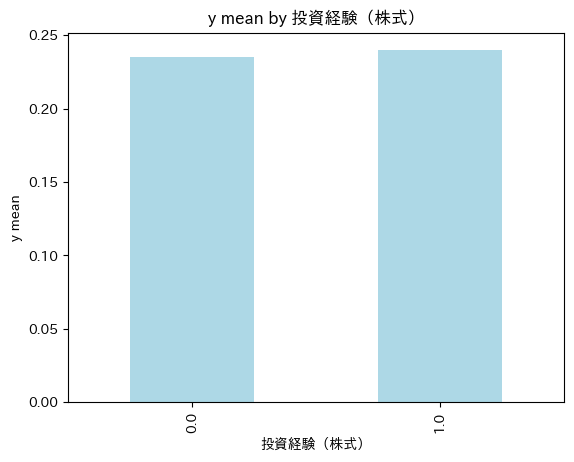

In [188]:
# 投資経験（株式）でグループ化し、各グループのyの平均値を計算
tmp = train_df.groupby('投資経験（株式）')['y'].mean()

# 棒グラフを作成（色は薄い青）
tmp.plot(kind='bar', color='lightblue')
# グラフのタイトルを設定
plt.title('y mean by 投資経験（株式）')
# Y軸のラベルを設定（yの平均値）
plt.ylabel('y mean')
# グラフを表示
plt.show()

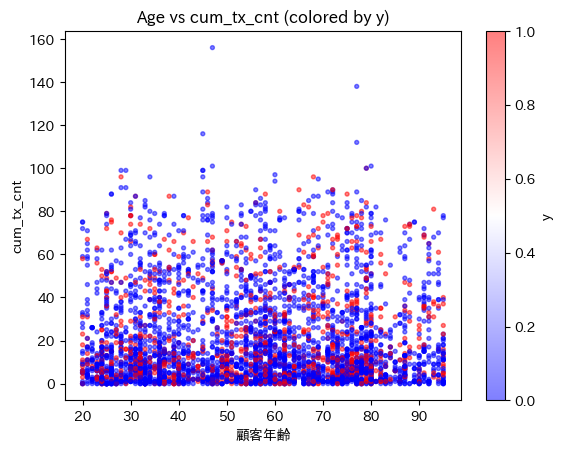

In [189]:
# データをサンプリング（最大5000件、元データが5000件未満なら全件使用）
# random_state=0で再現性を確保
df_s = train_df.sample(n=min(5000, len(train_df)), random_state=0)

# 散布図を作成
plt.scatter(
    df_s['顧客年齢'],      # X軸：顧客年齢
    df_s['cum_tx_cnt'],        # Y軸：cum_tx_cnt
    c=df_s['y'],          # 点の色：y値（0 or 1）で色分け
    cmap='bwr',           # カラーマップ：青白赤（blue-white-red）
    alpha=0.5,            # 透明度：0.5で半透明（重なりが見やすい）
    s=8                   # 点のサイズ：8ピクセル
)

# グラフのタイトルを設定
plt.title('Age vs cum_tx_cnt (colored by y)')
# X軸のラベルを設定
plt.xlabel('顧客年齢')
# Y軸のラベルを設定
plt.ylabel('cum_tx_cnt')
# カラーバーを追加（y値の凡例）
plt.colorbar(label='y')
# グラフを表示
plt.show()

金融商品の売買をする際には、取得額や時価以外にも、投資した金額に対してどれくらい儲かったか、あるいは損をしたか、というのも判断材料になりそうです。

「評価損益」を「取得価額」で割った「損益率」を計算し、その「損益率」と取引との関係を見てみます。

In [190]:
profit_check_df = train_df.copy()

profit_check_df['損益率'] = profit_check_df['評価損益'] / profit_check_df['取得価額']
profit_check_df.groupby('y')['損益率'].describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,52260.0,0.090072,0.178974,-1.000000,0.001077,0.031581,0.112351,1.786879
1,17845.0,0.091821,0.184044,-0.925019,0.001533,0.031788,0.112163,1.690000


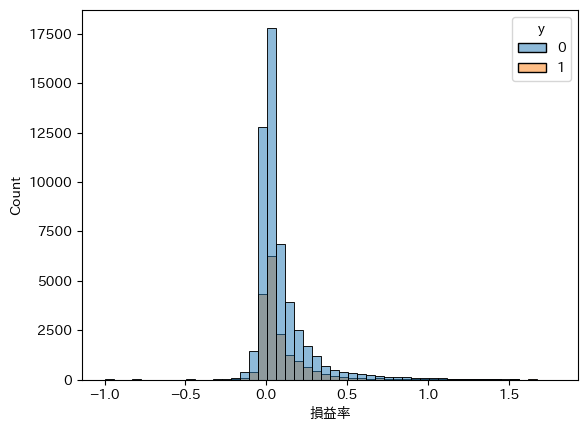

In [191]:
sns.histplot(data=profit_check_df, x='損益率', bins=50, hue='y')
plt.show()

統計量とヒストグラムから、損益率の違いによって取引行動が大きく違うということはなさそうです。

<a name="3"></a>
# 第3章：データの前処理



## 3-1. 特徴量の作成（特徴量エンジニアリング）

次に、既存のデータから新しい特徴量を作成します。これは「特徴量エンジニアリング」と呼ばれ、モデルの予測精度を向上させるための重要な工程です。ここでは一例として、EDAでも確認した「取得価額」に対する「評価損益」の割合を示す「損益率」という特徴量を作成してみます。


### 3-1-A 約定データからの特徴量作成と分析

約定データ (`execution_df`) を基に、顧客ごとの取引頻度や取引金額などの特徴量を作成し、`train_df` と結合して `y` との関係を分析します。

**注意**: 既存の `execution_df` は前処理済みの `exec_snap` にマージされていますが、ここでは元の `execution_df` を使って新たな特徴量を作成する例を示します。必要に応じて、前処理後のデータや他のデータソースも活用してください。

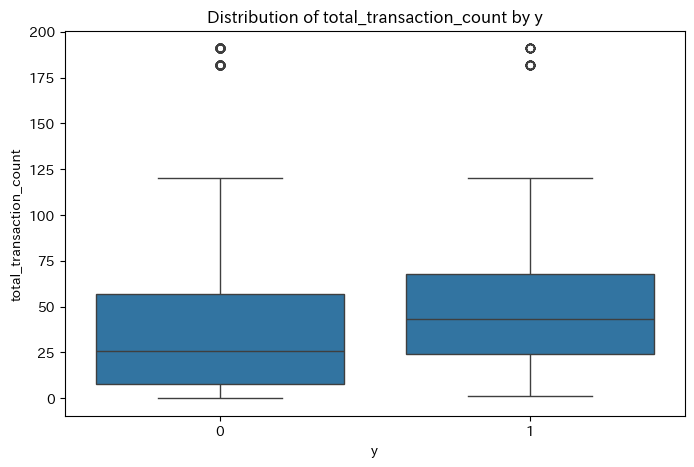

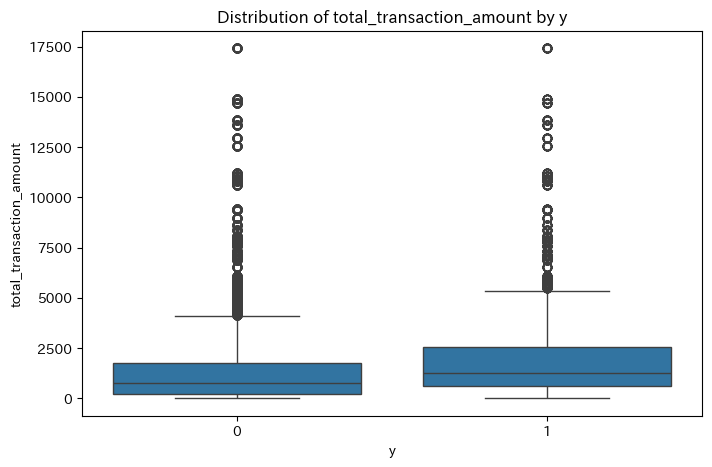

In [192]:
# 約定データから顧客ごとの取引回数を集計
customer_tx_count = execution_df.groupby('顧客ID').size().reset_index(name='total_transaction_count')

# 約定データから顧客ごとの総取引金額（取得価額 + 売却価額 + 償還価額）を集計
# Note: This line recalculates total_amount. Ensure it's the intended behavior if execution_df was already modified.
# If total_amount was already calculated and added to execution_df, this line can be removed or adjusted.
execution_df['total_amount'] = execution_df['取得価額'].fillna(0) + execution_df['売却価額'].fillna(0) + execution_df['償還価額'].fillna(0)
customer_total_amount = execution_df.groupby('顧客ID')['total_amount'].sum().reset_index(name='total_transaction_amount')

# マージ前に、train_dfとtest_dfに存在する可能性のある重複列を削除
cols_to_drop = [
    'total_transaction_count', 'total_transaction_amount',
    'total_transaction_count_x', 'total_transaction_amount_x',
    'total_transaction_count_y', 'total_transaction_amount_y'
]

for col in cols_to_drop:
    if col in train_df.columns:
        train_df = train_df.drop(columns=[col])
    if col in test_df.columns:
        test_df = test_df.drop(columns=[col])

# train_dfに結合（left join）
train_df = train_df.merge(customer_tx_count, on='顧客ID', how='left')
train_df = train_df.merge(customer_total_amount, on='顧客ID', how='left')

# test_dfにも結合（left join）
test_df = test_df.merge(customer_tx_count, on='顧客ID', how='left')
test_df = test_df.merge(customer_total_amount, on='顧客ID', how='left')


# 欠損値を0で補完（取引がない顧客は0回、0金額）
# マージ後に列が存在するか確認してからfillnaを実行
if 'total_transaction_count' in train_df.columns:
    train_df['total_transaction_count'] = train_df['total_transaction_count'].fillna(0)
if 'total_transaction_amount' in train_df.columns:
    train_df['total_transaction_amount'] = train_df['total_transaction_amount'].fillna(0)
if 'total_transaction_count' in test_df.columns:
    test_df['total_transaction_count'] = test_df['total_transaction_count'].fillna(0)
if 'total_transaction_amount' in test_df.columns:
    test_df['total_transaction_amount'] = test_df['total_transaction_amount'].fillna(0)


# 新しく作成した特徴量と y の関係を分析
transaction_features = ['total_transaction_count', 'total_transaction_amount']

for feature in transaction_features:
    if feature in train_df.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='y', y=feature, data=train_df)
        plt.title(f'Distribution of {feature} by y')
        plt.show()
    else:
         print(f"Feature '{feature}' not found in train_df.")

### 3-1-B 商品リストを活用した特徴量エンジニアリング（約定データとの結合）

`product_df` を活用して、`execution_df` に商品のカテゴリ情報を付与し、顧客の取引した商品の特性に関する特徴量を作成します。

In [193]:
# 商品リストから商品名、商品カテゴリ、リスクカテゴリを抽出
product_info = product_df[['商品名', '商品カテゴリ', 'リスクカテゴリ']].copy()

# execution_df に商品情報を結合
# 商品名をキーにleft joinします。
execution_df_with_product = execution_df.merge(product_info, on='商品名', how='left')

# 結合結果の確認
print(execution_df_with_product.head())

          取引日  顧客ID  取引コード                      商品名  取得価額      取得単価     取引数量  \
0  2015-04-01   269      3             Balance_fund  17.0       NaN    11.63   
1  2015-04-01   671      1                  JPY_spi   6.0    100.00   600.00   
2  2015-04-01   730      3  Global_Stock_Index_fund   5.0       NaN     5.20   
3  2015-04-01   950      1               2015_04_JP  51.0    100.59  5070.09   
4  2015-04-01   941      1               2015_04_US  56.0  12021.42    46.58   

      売却単価   売却価額  売却損益  償還価額  償還単価  償還損益 積立投資購入の新規/既存 購入開始年月 購入終了年月  \
0  17209.0  20.01  3.01   NaN   NaN   NaN          NaN    NaN    NaN   
1      NaN    NaN   NaN   NaN   NaN   NaN          NaN    NaN    NaN   
2  22355.0  11.62  6.62   NaN   NaN   NaN          NaN    NaN    NaN   
3      NaN    NaN   NaN   NaN   NaN   NaN          NaN    NaN    NaN   
4      NaN    NaN   NaN   NaN   NaN   NaN          NaN    NaN    NaN   

   オンライン取引フラグ  ゴール設定実施  ロスカット設定実施  ロスカット水準  total_amount              商品カテゴリ  \
0     

### 3-1-C 約定データと商品リストを組み合わせた特徴量エンジニアリング

結合した `execution_df_with_product` を使用して、顧客ごとの取引商品の多様性に関する特徴量を作成します。

In [194]:
# 顧客ごとの異なる商品カテゴリの取引数
customer_product_category_counts = execution_df_with_product.groupby('顧客ID')['商品カテゴリ'].nunique().reset_index(name='num_unique_product_categories')

# 顧客ごとの異なるリスクカテゴリの取引数
customer_risk_category_counts = execution_df_with_product.groupby('顧客ID')['リスクカテゴリ'].nunique().reset_index(name='num_unique_risk_categories')

# マージ前に、train_dfとtest_dfに存在する可能性のある重複列を削除
cols_to_drop = [
    'num_unique_product_categories', 'num_unique_risk_categories',
    'num_unique_product_categories_x', 'num_unique_risk_categories_x',
    'num_unique_product_categories_y', 'num_unique_risk_categories_y'
]

for col in cols_to_drop:
    if col in train_df.columns:
        train_df = train_df.drop(columns=[col])
    if col in test_df.columns:
        test_df = test_df.drop(columns=[col])


# train_dfに結合
train_df = train_df.merge(customer_product_category_counts, on='顧客ID', how='left')
train_df = train_df.merge(customer_risk_category_counts, on='顧客ID', how='left')


# 欠損値を0で補完（該当する取引がない顧客）
# マージ後に列が存在するか確認してからfillnaを実行
if 'num_unique_product_categories' in train_df.columns:
    train_df['num_unique_product_categories'] = train_df['num_unique_product_categories'].fillna(0)
if 'num_unique_risk_categories' in train_df.columns:
    train_df['num_unique_risk_categories'] = train_df['num_unique_risk_categories'].fillna(0)


# test_dfにも同様に結合
test_df = test_df.merge(customer_product_category_counts, on='顧客ID', how='left')
test_df = test_df.merge(customer_risk_category_counts, on='顧客ID', how='left')

# 欠損値を0で補完
# マージ後に列が存在するか確認してからfillnaを実行
if 'num_unique_product_categories' in test_df.columns:
    test_df['num_unique_product_categories'] = test_df['num_unique_product_categories'].fillna(0)
if 'num_unique_risk_categories' in test_df.columns:
    test_df['num_unique_risk_categories'] = test_df['num_unique_risk_categories'].fillna(0)


# 新しい特徴量の確認
print(train_df[['顧客ID', 'num_unique_product_categories', 'num_unique_risk_categories']].head())

   顧客ID  num_unique_product_categories  num_unique_risk_categories
0     1                            1.0                         1.0
1     1                            1.0                         1.0
2     1                            1.0                         1.0
3     1                            1.0                         1.0
4     1                            1.0                         1.0


これで、AIモデルの構築、学習、そして評価データに対する予測までの一連のプロセスが完了しました。
`y_pred_df` に格納された予測確率を使って、次の第5章で提出用ファイルを作成します。

### 3-1-D その他特徴量処理

In [195]:
# 損益率を計算
train_df['損益率'] = train_df['評価損益'] / train_df['取得価額']
test_df['損益率'] = test_df['評価損益'] / test_df['取得価額']

# 欠損の数を確認
print('損益率の欠損の数', train_df['損益率'].isnull().sum())

損益率の欠損の数 19895


In [196]:
#取引行動を計算
train_df['取引行動'] = np.where(train_df['cum_buy_cnt'] == 0,0,train_df['cum_amt_in']/train_df['cum_buy_cnt'])
test_df['取引行動'] = np.where(test_df['cum_buy_cnt'] == 0,0,test_df['cum_amt_in']/test_df['cum_buy_cnt'])

print('欠損の数', train_df['取引行動'].isnull().sum())

欠損の数 0


欠損値がありますので後で処理が必要です。

In [200]:
# 約定データを顧客IDと取引日でソート
execution_df_sorted = execution_df.sort_values(['顧客ID', '取引日']).copy()

# '取引日'列をdatetime型に変換（念のため再実行）
execution_df_sorted['取引日'] = pd.to_datetime(execution_df_sorted['取引日'], errors='coerce')
execution_df_sorted = execution_df_sorted.dropna(subset=['取引日'])


# 顧客ごとに取引間隔を計算
# diff()で直前の取引日との差分を計算し、dt.daysで日数に変換
execution_df_sorted['取引間隔_days'] = execution_df_sorted.groupby('顧客ID')['取引日'].diff().dt.days

# 各顧客の取引間隔の要約統計量を計算
# NaN（最初の取引の取引間隔は計算できない）は除外して集計
customer_tx_interval_stats = execution_df_sorted.groupby('顧客ID')['取引間隔_days'].agg(
    ['mean', 'min', 'max', 'median', 'std', 'count']
).reset_index()

# 列名を変更
customer_tx_interval_stats.columns = [
    '顧客ID',
    'tx_interval_mean',     # 平均取引間隔
    'tx_interval_min',       # 最小取引間隔
    'tx_interval_max',       # 最大取引間隔
    'tx_interval_median', # 中央値取引間隔
    'tx_interval_std',       # 取引間隔の標準偏差
    'tx_interval_count'    # 取引間隔が計算できた回数 (取引回数-1に相当)
]


# 標準偏差のNaNを0で補完（取引間隔が1つしかない顧客など）
customer_tx_interval_stats['tx_interval_std'] = customer_tx_interval_stats['tx_interval_std'].fillna(0)


# train_dfとtest_dfに結合
# マージ前に、train_dfとtest_dfに存在する可能性のある重複列を削除
cols_to_drop = [col for col in customer_tx_interval_stats.columns if col != '顧客ID' and col in train_df.columns]
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore')


train_df = train_df.merge(customer_tx_interval_stats, on='顧客ID', how='left')
test_df = test_df.merge(customer_tx_interval_stats, on='顧客ID', how='left')

# 新しく作成した特徴量を確認（最初の5行と欠損値の数）
print("新しく作成した取引間隔関連の特徴量（train_df）:")
print(train_df[['顧客ID', 'tx_interval_mean', 'tx_interval_min', 'tx_interval_max', 'tx_interval_median', 'tx_interval_std', 'tx_interval_count']].head())

print("\n新しく作成した取引間隔関連の特徴量（test_df）:")
print(test_df[['顧客ID', 'tx_interval_mean', 'tx_interval_min', 'tx_interval_max', 'tx_interval_median', 'tx_interval_std', 'tx_interval_count']].head())

print("\n取引間隔関連の特徴量の欠損値数（train_df）:")
print(train_df[['tx_interval_mean', 'tx_interval_min', 'tx_interval_max', 'tx_interval_median', 'tx_interval_std', 'tx_interval_count']].isnull().sum())

print("\n補完後の取引間隔関連の特徴量の欠損値数（test_df）:")
print(test_df[['tx_interval_mean', 'tx_interval_min', 'tx_interval_max', 'tx_interval_median', 'tx_interval_std', 'tx_interval_count']].isnull().sum())

新しく作成した取引間隔関連の特徴量（train_df）:
   顧客ID  tx_interval_mean  tx_interval_min  tx_interval_max  \
0     1               NaN              NaN              NaN   
1     1               NaN              NaN              NaN   
2     1               NaN              NaN              NaN   
3     1               NaN              NaN              NaN   
4     1               NaN              NaN              NaN   

   tx_interval_median  tx_interval_std  tx_interval_count  
0                 NaN              0.0                0.0  
1                 NaN              0.0                0.0  
2                 NaN              0.0                0.0  
3                 NaN              0.0                0.0  
4                 NaN              0.0                0.0  

新しく作成した取引間隔関連の特徴量（test_df）:
   顧客ID  tx_interval_mean  tx_interval_min  tx_interval_max  \
0     1               NaN              NaN              NaN   
1     1               NaN              NaN              NaN   
2     1       

In [201]:
# 取引間隔関連の特徴量の欠損値を補完
# 取引がない顧客はこれらの統計量を持たないので、0で補完するのが自然と考えられます。
interval_cols = [
    'tx_interval_mean',
    'tx_interval_min',
    'tx_interval_max',
    'tx_interval_median',
    'tx_interval_std',
    'tx_interval_count'
]

for col in interval_cols:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(0)
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(0)

print("取引間隔関連の特徴量の欠損値を0で補完しました。")

# 補完後の欠損値数を確認
print("\n補完後の取引間隔関連の特徴量の欠損値数（train_df）:")
print(train_df[interval_cols].isnull().sum())

print("\n補完後の取引間隔関連の特徴量の欠損値数（test_df）:")
print(test_df[interval_cols].isnull().sum())

取引間隔関連の特徴量の欠損値を0で補完しました。

補完後の取引間隔関連の特徴量の欠損値数（train_df）:
tx_interval_mean      0
tx_interval_min       0
tx_interval_max       0
tx_interval_median    0
tx_interval_std       0
tx_interval_count     0
dtype: int64

補完後の取引間隔関連の特徴量の欠損値数（test_df）:
tx_interval_mean      0
tx_interval_min       0
tx_interval_max       0
tx_interval_median    0
tx_interval_std       0
tx_interval_count     0
dtype: int64


In [202]:
# 欠損値を補完
train_df['顧客年齢'] = train_df['顧客年齢'].fillna(train_df['顧客年齢'].mean()) # 顧客年齢は平均値で補完
test_df['顧客年齢'] = test_df['顧客年齢'].fillna(test_df['顧客年齢'].mean())
train_df['投資経験（株式）'] = train_df['投資経験（株式）'].fillna(0) # 投資経験（株式）は0で補完
test_df['投資経験（株式）'] = test_df['投資経験（株式）'].fillna(0)
train_df['投資経験（投資信託）'] = train_df['投資経験（投資信託）'].fillna(0)
test_df['投資経験（投資信託）'] = test_df['投資経験（投資信託）'].fillna(0)
train_df['投資経験（国内債券）'] = train_df['投資経験（国内債券）'].fillna(0)
test_df['投資経験（国内債券）'] = test_df['投資経験（国内債券）'].fillna(0)
train_df['投資経験（外国債券）'] = train_df['投資経験（外国債券）'].fillna(0)
test_df['投資経験（外国債券）'] = test_df['投資経験（外国債券）'].fillna(0)
train_df['投資経験（仕組債）'] = train_df['投資経験（仕組債）'].fillna(0)
test_df['投資経験（仕組債）'] = test_df['投資経験（仕組債）'].fillna(0)
train_df['投資経験（一時払保険）'] = train_df['投資経験（一時払保険）'].fillna(0)
test_df['投資経験（一時払保険）'] = test_df['投資経験（一時払保険）'].fillna(0)
train_df['投資経験（外貨建一時払保険）'] = train_df['投資経験（外貨建一時払保険）'].fillna(0)
test_df['投資経験（外貨建一時払保険）'] = test_df['投資経験（外貨建一時払保険）'].fillna(0)
train_df['投資経験（外国株式）'] = train_df['投資経験（外国株式）'].fillna(0)
test_df['投資経験（外国株式）'] = test_df['投資経験（外国株式）'].fillna(0)
train_df['投資経験（外貨預金）'] = train_df['投資経験（外貨預金）'].fillna(0)
test_df['投資経験（外貨預金）'] = test_df['投資経験（外貨預金）'].fillna(0)

# 経過日数（実績なしは大きな固定値で補完）＋ 実績有無フラグ
BIG_DAYS = 9999

train_df['has_tx_history'] = (~train_df['days_since_last_tx'].isna()).astype(int)
test_df['has_tx_history']  = (~test_df['days_since_last_tx'].isna()).astype(int)
train_df['days_since_last_tx'] = train_df['days_since_last_tx'].fillna(BIG_DAYS)
test_df['days_since_last_tx']  = test_df['days_since_last_tx'].fillna(BIG_DAYS)

train_df['has_hold_history'] = (~train_df['days_since_last_holding'].isna()).astype(int)
test_df['has_hold_history']  = (~test_df['days_since_last_holding'].isna()).astype(int)
train_df['days_since_last_holding'] = train_df['days_since_last_holding'].fillna(BIG_DAYS)
test_df['days_since_last_holding']  = test_df['days_since_last_holding'].fillna(BIG_DAYS)

# 行動・保有の要約特徴は0で補完
train_df['buy_cat_n_day']       = train_df['buy_cat_n_day'].fillna(0)
test_df['buy_cat_n_day']        = test_df['buy_cat_n_day'].fillna(0)
train_df['cum_buy_cat_n_proxy'] = train_df['cum_buy_cat_n_proxy'].fillna(0)
test_df['cum_buy_cat_n_proxy']  = test_df['cum_buy_cat_n_proxy'].fillna(0)

train_df['cum_tx_cnt']   = train_df['cum_tx_cnt'].fillna(0)
test_df['cum_tx_cnt']    = test_df['cum_tx_cnt'].fillna(0)
train_df['cum_buy_cnt']  = train_df['cum_buy_cnt'].fillna(0)
test_df['cum_buy_cnt']   = test_df['cum_buy_cnt'].fillna(0)
train_df['cum_sell_cnt'] = train_df['cum_sell_cnt'].fillna(0)
test_df['cum_sell_cnt']  = test_df['cum_sell_cnt'].fillna(0)

train_df['cum_amt_in']  = train_df['cum_amt_in'].fillna(0)
test_df['cum_amt_in']   = test_df['cum_amt_in'].fillna(0)
train_df['cum_amt_out'] = train_df['cum_amt_out'].fillna(0)
test_df['cum_amt_out']  = test_df['cum_amt_out'].fillna(0)

train_df['mv_total']              = train_df['mv_total'].fillna(0)
test_df['mv_total']               = test_df['mv_total'].fillna(0)
train_df['pl_total']              = train_df['pl_total'].fillna(0)
test_df['pl_total']               = test_df['pl_total'].fillna(0)
train_df['n_positions']           = train_df['n_positions'].fillna(0)
test_df['n_positions']            = test_df['n_positions'].fillna(0)
train_df['tsumitate_flag_any']    = train_df['tsumitate_flag_any'].fillna(0)
test_df['tsumitate_flag_any']     = test_df['tsumitate_flag_any'].fillna(0)
train_df['tsumitate_monthly_amt'] = train_df['tsumitate_monthly_amt'].fillna(0)
test_df['tsumitate_monthly_amt']  = test_df['tsumitate_monthly_amt'].fillna(0)

# 通貨別（使っていないが列があれば0補完）
train_df['mv_JPY'] = train_df['mv_JPY'].fillna(0)
test_df['mv_JPY']  = test_df['mv_JPY'].fillna(0)
train_df['mv_USD'] = train_df['mv_USD'].fillna(0)
test_df['mv_USD']  = test_df['mv_USD'].fillna(0)
train_df['mv_AUD'] = train_df['mv_AUD'].fillna(0)
test_df['mv_AUD']  = test_df['mv_AUD'].fillna(0)

# 日付列は学習で使わないため削除（存在しなければ無視）
train_df = train_df.drop(columns=['last_tx_date','last_holding_date'], errors='ignore')
test_df  = test_df.drop(columns=['last_tx_date','last_holding_date'], errors='ignore')

# 取得価額が0の場合に発生する無限大や欠損値を0で補完
train_df['損益率'] = train_df['損益率'].replace([np.inf, -np.inf], np.nan).fillna(0)
test_df['損益率'] = test_df['損益率'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 欠損値処理後の train_df の情報
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ID                             90000 non-null  int64         
 1   顧客ID                           90000 non-null  int64         
 2   住所コード                          90000 non-null  object        
 3   顧客氏名                           90000 non-null  object        
 4   基準年月                           90000 non-null  datetime64[ns]
 5   取得価額                           90000 non-null  float64       
 6   時価価額                           90000 non-null  float64       
 7   評価損益                           90000 non-null  float64       
 8   投資方針                           90000 non-null  int64         
 9   train_term_1                   90000 non-null  int64         
 10  train_term_2                   90000 non-null  int64         
 11  train_term_3   

## 3-4. データ型の変換

AIモデルは、基本的に数値データを入力として受け取ります。`住所コード` や `基準年月` といった文字列データは、そのままではモデルが解釈できないため、数値に変換する必要があります。

ここでは、`基準年月` から「年」と「月」を数値として抽出します。  
`住所コード` と `投資方針` については、後ほどカテゴリの各値を独立した列として表現する「ワンホットエンコーディング」を適用します。

※ 参考教材へのリンク... [split()関数の使い方](https://biz.quest.signate.jp/quests/10003/contents/1/4/2)

In [203]:
# 「基準年月」から「年」と「月」を抽出
train_df['year'] = train_df['基準年月'].dt.year
train_df['month'] = train_df['基準年月'].dt.month

test_df['year'] = test_df['基準年月'].dt.year
test_df['month'] = test_df['基準年月'].dt.month

In [204]:
# カテゴリ列（住所コード）のエンコーディング：ラベル/ワンホット選択可能 ---

def encode_categorical_column(train_df, test_df, column_name, encoding_type='label'):
    """
    カテゴリ列をラベルエンコーディングまたはワンホットエンコーディングする
    scikit-learnのエンコーダーを使用

    Args:
        train_df: 訓練データ
        test_df: テストデータ
        column_name: エンコード対象の列名
        encoding_type: 'label' または 'onehot'

    Returns:
        エンコード済みの train_df, test_df
    """
    if encoding_type == 'onehot':
        le = LabelEncoder()

        # 訓練データのみでエンコーダーを学習
        le.fit(train_df[column_name].astype(str))

        # 訓練データの変換
        train_df[f'{column_name}_enc'] = le.transform(train_df[column_name].astype(str))

        # テストデータの変換（未知の値への対処）
        test_values = test_df[column_name].astype(str)
        known_classes = set(le.classes_)

        test_encoded = []
        for val in test_values:
            if val in known_classes:
                test_encoded.append(le.transform([val])[0])
            else:
                test_encoded.append(-1)  # 未知の値は-1
        test_df[f'{column_name}_enc'] = test_encoded

    elif encoding_type == 'onehot':
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

        # 訓練データのみでエンコーダーを学習
        ohe.fit(train_df[[column_name]].astype(str))

        # 変換
        train_encoded = ohe.transform(train_df[[column_name]].astype(str))
        test_encoded = ohe.transform(test_df[[column_name]].astype(str))

        # DataFrame化（カラム名は同じになる）
        feature_names = [f'{column_name}_{cat}' for cat in ohe.categories_[0]]

        train_encoded_df = pd.DataFrame(
            train_encoded,
            columns=feature_names,
            index=train_df.index
        )

        test_encoded_df = pd.DataFrame(
            test_encoded,
            columns=feature_names,
            index=test_df.index
        )

        # 元のデータフレームに結合
        train_df = pd.concat([train_df, train_encoded_df], axis=1)
        test_df = pd.concat([test_df, test_encoded_df], axis=1)

    else:
        raise ValueError(f"encoding_type must be 'label' or 'onehot', got {encoding_type}")

    return train_df, test_df

    """
    if encoding_type == 'label':
        # ===== LabelEncoderを使用したラベルエンコーディング =====
        le = LabelEncoder()

        # train/test両方の値でエンコーダーを学習
        all_values = pd.concat([
            train_df[column_name].astype(str),
            test_df[column_name].astype(str)
        ])
        le.fit(all_values)

        # 訓練データの変換
        train_df[f'{column_name}_enc'] = le.transform(train_df[column_name].astype(str))

        # テストデータの変換（未知の値への対処）
        test_values = test_df[column_name].astype(str)
        # 未知の値を検出
        known_classes = set(le.classes_)
        test_values_adjusted = test_values.apply(
            lambda x: x if x in known_classes else 'unknown'
        )

        # 'unknown'をエンコーダーに追加して変換
        if 'unknown' in test_values_adjusted.values and 'unknown' not in le.classes_:
            # 未知の値は-1として扱う
            test_encoded = []
            for val in test_values:
                if val in known_classes:
                    test_encoded.append(le.transform([val])[0])
                else:
                    test_encoded.append(-1)  # 未知の値は-1
            test_df[f'{column_name}_enc'] = test_encoded
        else:
            test_df[f'{column_name}_enc'] = le.transform(test_values_adjusted)

    elif encoding_type == 'onehot':
        # ===== OneHotEncoderを使用したワンホットエンコーディング =====
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

        # train/test両方の値でエンコーダーを学習
        all_values = pd.concat([
            train_df[[column_name]].astype(str),
            test_df[[column_name]].astype(str)
        ])
        ohe.fit(all_values)

        # 変換とDataFrame化
        # 訓練データ
        train_encoded = ohe.transform(train_df[[column_name]].astype(str))
        train_encoded_df = pd.DataFrame(
            train_encoded,
            columns=[f'{column_name}_{cat}' for cat in ohe.categories_[0]],
            index=train_df.index
        )

        # テストデータ
        test_encoded = ohe.transform(test_df[[column_name]].astype(str))
        test_encoded_df = pd.DataFrame(
            test_encoded,
            columns=[f'{column_name}_{cat}' for cat in ohe.categories_[0]],
            index=test_df.index
        )

        # 元のデータフレームに結合
        train_df = pd.concat([train_df, train_encoded_df], axis=1)
        test_df = pd.concat([test_df, test_encoded_df], axis=1)

    else:
        raise ValueError(f"encoding_type must be 'label' or 'onehot', got {encoding_type}")

    return train_df, test_df
    """



# エンコーディング方式を選択（'label' or 'onehot'）
ENCODING_TYPE = 'onehot'  # ← ここを変更することで切り替え可能

# 住所コードのエンコーディング実行
train_df, test_df = encode_categorical_column(
    train_df,
    test_df,
    column_name='住所コード',
    encoding_type=ENCODING_TYPE
)

In [205]:
# 月次保有明細データを顧客IDと基準日でソート
monthly_holdings_df['基準日'] = pd.to_datetime(monthly_holdings_df['基準日'], errors='coerce')
monthly_holdings_df = monthly_holdings_df.dropna(subset=['基準日'])
monthly_holdings_df = monthly_holdings_df.sort_values(['顧客ID', '基準日']).reset_index(drop=True)

# 顧客ごとの基準日ごとの時価価額の合計を計算
monthly_holdings_agg = monthly_holdings_df.groupby(['顧客ID', '基準日'])['時価価額'].sum().reset_index()

# 結果を確認
print(monthly_holdings_agg.head())

   顧客ID        基準日    時価価額
0     1 2015-04-30  441.15
1     3 2015-04-30  540.24
2     3 2015-05-29  586.37
3     3 2015-06-30  585.62
4     3 2015-07-31  586.56


In [206]:
# 予測に用いる特徴量

# エンコーディング方式を選択（'label' or 'onehot'）
ENCODING_TYPE = 'label'  # ← ここを変更することで切り替え可能

# 基本の特徴量リスト（住所コード関連を除く）
feature_columns_base = [
    # ベース属性（住所コード_encを除く）
    '顧客ID', '投資方針', '顧客年齢',
    # 投資経験（すべて採用）
    '投資経験（投資信託）','投資経験（国内債券）','投資経験（外国債券）','投資経験（仕組債）',
    '投資経験（一時払保険）','投資経験（外貨建一時払保険）','投資経験（株式）',
    '投資経験（外国株式）','投資経験経験（外貨預金）',
    # 行動履歴（execution由来）
    'cum_tx_cnt','cum_buy_cnt','cum_sell_cnt','cum_amt_in','cum_amt_out',
    'buy_cat_n_day','cum_buy_cat_n_proxy','buy_risk_n_day','cum_buy_risk_n_proxy','days_since_last_tx','has_tx_history','取引行動',
    # 保有スナップショット（monthly_holdings由来）
    'mv_total','pl_total','n_positions','tsumitate_flag_any','tsumitate_monthly_amt',
    'days_since_last_holding','has_hold_history',
    # 当月情報
    '取得価額','時価価額','評価損益','損益率',
    # 時間特徴
    'year','month',
    # 追加した新しい特徴量 (以前作成したもの)
    'total_transaction_count',
    'total_transaction_amount',
    'num_unique_product_categories',
    'num_unique_risk_categories',
    # 新しく追加した取引間隔関連の特徴量
    'tx_interval_mean',
    'tx_interval_min',
    'tx_interval_max',
    'tx_interval_median',
    'tx_interval_std',
    'tx_interval_count',
]

if ENCODING_TYPE == 'onehot':
    # ワンホットエンコーディングされた住所コード列を動的に取得
    address_onehot_columns = [col for col in train_df.columns if col.startswith('住所コード_')]

    # 最終的な特徴量リスト（ワンホットエンコーディング版）
    feature_columns = feature_columns_base + address_onehot_columns
elif ENCODING_TYPE == 'label':
    # ラベルエンコーディングされた住所コード
    feature_columns = feature_columns_base + ['住所コード_enc']

# 念のため、実在しない列が混じっていれば落とす（実データの安全対策）
feature_columns = [c for c in feature_columns if c in train_df.columns]

In [207]:
# 全期間平均の特徴量重要度を取得
# 前のセルで計算したavg_importanceを使用
if 'avg_importance' not in locals():
    print("エラー: 'avg_importance' が見つかりません。特徴量重要度を計算するセルを先に実行してください。")
else:
    # 全期間平均で上位30の特徴量を選択
    top30_features = avg_importance.head(30).index.tolist()

    # 現在の特徴量リストを取得
    current_feature_columns = feature_columns # 前に定義した feature_columns を使用

    # 削除する特徴量リストを作成 (現在の特徴量リストからTop 30に含まれないものを抽出)
    features_to_remove = [
        col for col in current_feature_columns
        if col not in top30_features
    ]

    # train_dfとtest_dfから不要な特徴量を削除 (元のDataFrameから直接削除)
    # 念のため、削除対象の列がDataFrameに存在するか確認してから削除します
    cols_to_drop_train = [col for col in features_to_remove if col in train_df.columns]
    cols_to_drop_test = [col for col in features_to_remove if col in test_df.columns]

    if cols_to_drop_train:
        train_df = train_df.drop(columns=cols_to_drop_train)
        print(f"train_dfから以下の特徴量を削除しました: {cols_to_drop_train}")
    else:
        print("train_dfに削除対象の特徴量はありませんでした。")

    if cols_to_drop_test:
        test_df = test_df.drop(columns=cols_to_drop_test)
        print(f"test_dfから以下の特徴量を削除しました: {cols_to_drop_test}")
    else:
        print("test_dfに削除対象の特徴量はありませんでした。")


    # モデル学習に使用する特徴量リストを更新
    # Top 30の特徴量リストをそのまま使用します
    feature_columns = top30_features

    print(f"\nモデル学習に使用する特徴量リストをTop 30に更新しました。特徴量数: {len(feature_columns)}")
    print("更新された特徴量リストの最初の10件:")
    print(feature_columns[:10])

    # 更新された学習用・テスト用データフレームを再作成
    # これは前のセルのコードを再実行するのと同じですが、明示的にここでデータフレームを更新します。
    X_train_dfs = {}
    for i in range(1, 7):
        # train_dfは既に不要な列が削除されているため、feature_columnsでフィルタリング
        X_train_dfs[f'X_train_{i}'] = train_df[train_df[f'train_term_{i}'] == 1][feature_columns]

    X_test_dfs = {}
    for i in range(1, 7):
        # test_dfも既に不要な列が削除されているため、feature_columnsでフィルタリング
        X_test_dfs[f'X_test_{i}'] = test_df[test_df[f'test_term_{i}'] == 1][feature_columns]

    print("\nTop 30の特徴量で学習用・テスト用データを再作成しました。")

train_dfから以下の特徴量を削除しました: ['顧客ID', '投資方針', '投資経験（投資信託）', '投資経験（国内債券）', '投資経験（外国債券）', '投資経験（一時払保険）', '投資経験（株式）', 'cum_sell_cnt', 'cum_buy_cat_n_proxy', 'buy_risk_n_day', 'has_tx_history', 'mv_total', 'pl_total', 'has_hold_history', '損益率', 'month', 'num_unique_risk_categories']
test_dfから以下の特徴量を削除しました: ['顧客ID', '投資方針', '投資経験（投資信託）', '投資経験（国内債券）', '投資経験（外国債券）', '投資経験（一時払保険）', '投資経験（株式）', 'cum_sell_cnt', 'cum_buy_cat_n_proxy', 'buy_risk_n_day', 'has_tx_history', 'mv_total', 'pl_total', 'has_hold_history', '損益率', 'month', 'num_unique_risk_categories']

モデル学習に使用する特徴量リストをTop 30に更新しました。特徴量数: 30
更新された特徴量リストの最初の10件:
['days_since_last_holding', '取得価額', 'tsumitate_flag_any', 'tx_interval_count', '時価価額', 'total_transaction_count', 'tx_interval_median', 'num_unique_product_categories', 'tx_interval_std', 'tx_interval_mean']

Top 30の特徴量で学習用・テスト用データを再作成しました。


すべてのカラムが数値型になっているかどうか確認します。

In [208]:
# 数値型カラムと文字型カラムの数を調べる
numeric_cols = train_df[feature_columns].select_dtypes(include=np.number).columns
string_cols = train_df[feature_columns].select_dtypes(include='object').columns

print(f"数値型カラムの数: {len(numeric_cols)}")
print(f"文字型カラムの数: {len(string_cols)}")

数値型カラムの数: 30
文字型カラムの数: 0


これと同様のことを予測期間1から6まで、6回繰り返すことで各予測期間用の学習データが作成できます。同じことの繰り返しであるため、for文を使って書くことができます。

同様にfor文を使って、目的変数である `y` についても6つの予測期間に対応するデータを作成しておきます。

In [209]:
# y_train_dfsというリストに6つの予測期間に対応するyを格納する
y_train_dfs = {}
for i in range(1, 7):
    y_train_dfs[f'y_train_{i}'] = train_df[train_df[f'train_term_{i}'] == 1]['y']

In [210]:
# X_train_dfsというリストに6つの予測期間に対応する学習データを格納する
X_train_dfs = {}
for i in range(1, 7):
    X_train_dfs[f'X_train_{i}'] = train_df[train_df[f'train_term_{i}'] == 1][feature_columns]

# 特徴量リストの更新後に、テストデータも再作成します
X_test_dfs = {}
for i in range(1, 7):
    X_test_dfs[f'X_test_{i}'] = test_df[test_df[f'test_term_{i}'] == 1][feature_columns]

print("特徴量リストを更新し、学習用・テスト用データを再作成しました。")

特徴量リストを更新し、学習用・テスト用データを再作成しました。


## 3-6. テスト用データの作成

最後に、学習用データと同様にテスト用データを作成します。

In [211]:
X_test_dfs = {}
for i in range(1, 7):
    X_test_dfs[f'X_test_{i}'] = test_df[test_df[f'test_term_{i}'] == 1][feature_columns]

これで、学習用データとテスト用データの両方で、モデル構築に進むための前処理が完了しました。
次の第4章では、これらのデータを使って実際にAIモデルを構築し、学習・予測を行います。

<a name="4"></a>
# 第4章：予測モデルの構築と評価

第3章では、AIモデルが学習しやすいようにデータを整える「前処理」を行いました。これで、モデル構築のための準備が整いました。
この章では、いよいよAIモデルを構築し、前処理済みのデータを使って学習させ、顧客が取引を行う確率を予測するステップに進みます。


## 4-1. 未知のデータに対する予測（全予測期間）

6つの予測期間に対してモデルの学習を行います。
for文を用いて決定木の作成を6回繰り返しますので、モデルの構築に少し時間がかかります。

In [222]:
# ===== 使用モデルを選択 =====
# 'dt'（DecisionTree）, 'lr'（ロジスティック回帰）, 'rf'（ランダムフォレスト）, 'lgbm'（LightGBM）, 'laml'（LightAutoML）
MODEL_KIND = 'xgb'

In [223]:
# モデルと特徴量名を格納する辞書を初期化
models = {}
feature_names_by_term = {}

# 6つの期間（term）ごとにモデルを学習
for i in range(1, 7):
    # 現在の期間用の訓練データを取得
    X_train = X_train_dfs[f'X_train_{i}']
    y_train = y_train_dfs[f'y_train_{i}']

    # この期間で使用する特徴量名を記録（後で重要度分析などに使用）
    feature_names_by_term[i] = X_train.columns.tolist()

    # ===== 使用モデルを選択 =====
    # 'lr'（ロジスティック回帰）, 'rf'（ランダムフォレスト）, 'lgbm'（LightGBM）, 'laml'（LightAutoML）, 'xgb'（XGBoost）
    MODEL_KIND = 'xgb' # ここでモデルの種類を選択

    # ===== 決定木 =====
    if MODEL_KIND == 'dt':
        # 決定木分類器を初期化（過学習防止のため最小葉サンプル数10）
        model = DecisionTreeClassifier(random_state=0, min_samples_leaf=10)
        # モデルを学習
        model.fit(X_train, y_train)

    # ===== ロジスティック回帰 =====
    elif MODEL_KIND == 'lr':
        # ロジスティック回帰を初期化（最大反復回数1000、L-BFGS法使用）
        # ConvergenceWarningが出る場合はmax_iterを増やすか、データをスケーリング
        model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=0)
        # モデルを学習
        model.fit(X_train, y_train)

    # ===== ランダムフォレスト =====
    elif MODEL_KIND == 'rf':
        # ランダムフォレストを初期化
        # n_estimators=300: 決定木300本、min_samples_leaf=10: 過学習防止
        # n_jobs=-1: 全CPUコア使用で並列処理
        model = RandomForestClassifier(n_estimators=300, min_samples_leaf=10, n_jobs=-1, random_state=0)
        # モデルを学習
        model.fit(X_train, y_train)

    # ===== LightGBM =====
    elif MODEL_KIND == 'lgbm':
        # LightGBM分類器を初期化
        model = LGBMClassifier(
            n_estimators=500,           # ブースティング回数500
            learning_rate=0.05,         # 学習率（小さめで安定学習）
            subsample=0.8,              # 行サンプリング率80%
            colsample_bytree=0.8,       # 列サンプリング率80%
            max_depth=-1,               # 深さ制限なし
            random_state=0              # 再現性確保
        )
        # モデルを学習
        model.fit(X_train, y_train)

    # ===== XGBoost =====
    elif MODEL_KIND == 'xgb':
        # XGBoost分類器を初期化
        from xgboost import XGBClassifier
        model = XGBClassifier(
            n_estimators=500,           # ブースティング回数を500に変更
            learning_rate=0.05,         # 学習率を0.05に変更
            subsample=0.8,              # 行サンプリング率
            colsample_bytree=0.8,       # 列サンプリング率
            max_depth=6,                # 木の最大深度
            eval_metric='logloss',      # 評価指標 (二値分類用)
            random_state=0,             # 再現性確保
            n_jobs=-1                   # 全CPUコア使用
        )
        # モデルを学習
        model.fit(X_train, y_train)


    # ===== AutoML (LAML) =====
    elif MODEL_KIND == 'laml':
        # AutoMLの実行時間上限を設定（60秒 = 1分）
        LAMLA_TIMEOUT_SEC = 60

        # LAMLフォーマット用にデータを準備（X_trainとy_trainを結合）
        train_tab = X_train.copy()
        train_tab['y'] = y_train.values

        # 二値分類タスクとして設定
        task = Task('binary')

        # TabularAutoMLを初期化（timeout秒で自動的に最適化を停止）
        model = TabularAutoML(task=task, timeout=LAMLA_TIMEOUT_SEC)

        # モデルを学習（target列を'y'として指定）
        _ = model.fit_predict(train_tab, roles={'target': 'y'})

    # ===== 未定義のモデル種別の場合 =====
    else:
        raise ValueError("MODEL_KIND は 'dt' | 'lr' | 'rf' | 'lgbm' | 'laml' | 'xgb' から選択してください。")

    # 学習済みモデルを辞書に保存（期間ごとに管理）
    models[f'model_{i}'] = model

print("全ての期間でモデル学習が完了しました。")

全ての期間でモデル学習が完了しました。



===== Term 1 の特徴量重要度 =====

Term 1 - Top 20 重要な特徴量:


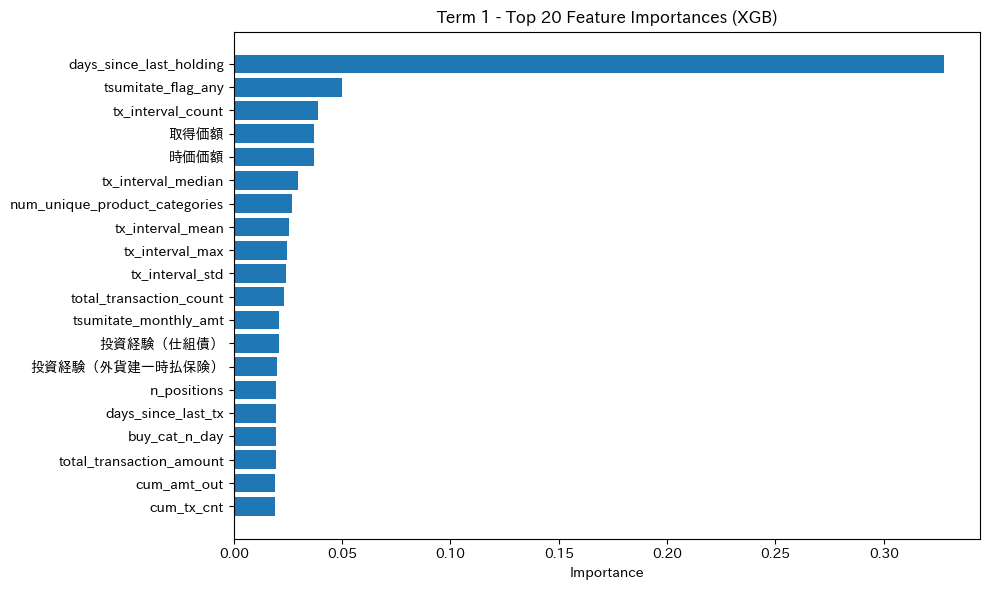


===== Term 2 の特徴量重要度 =====

Term 2 - Top 20 重要な特徴量:


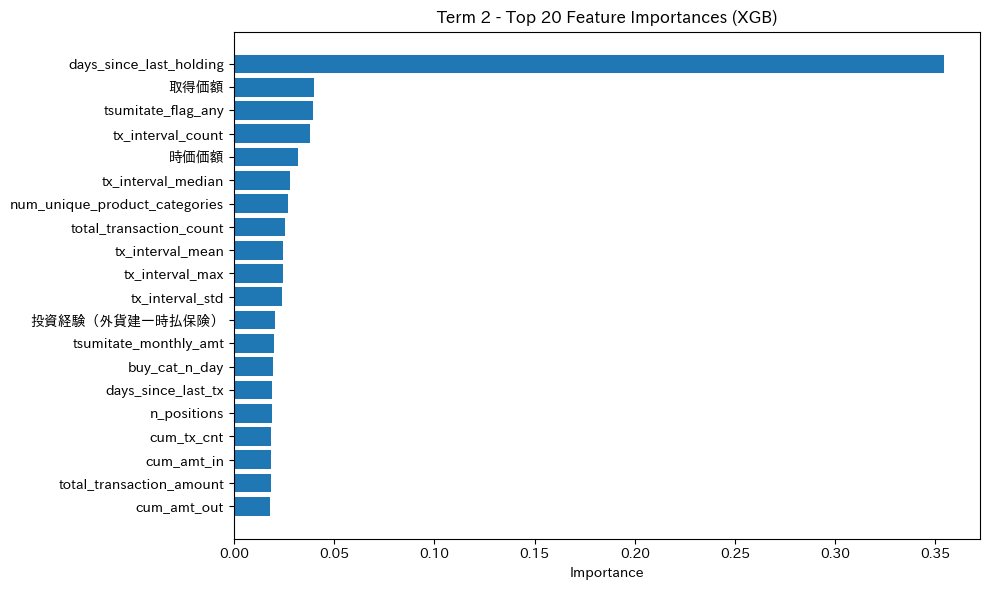


===== Term 3 の特徴量重要度 =====

Term 3 - Top 20 重要な特徴量:


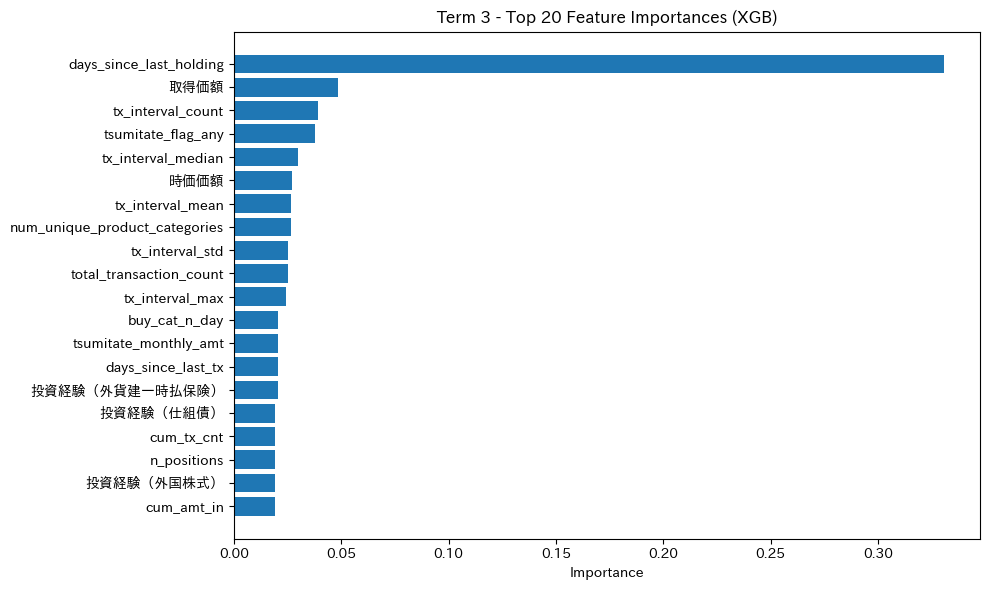


===== Term 4 の特徴量重要度 =====

Term 4 - Top 20 重要な特徴量:


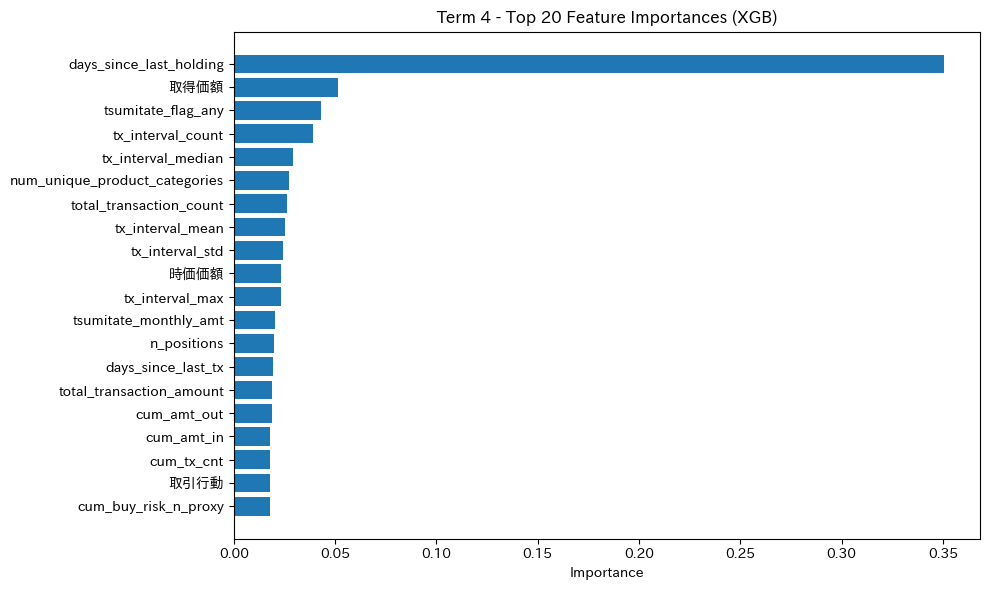


===== Term 5 の特徴量重要度 =====

Term 5 - Top 20 重要な特徴量:


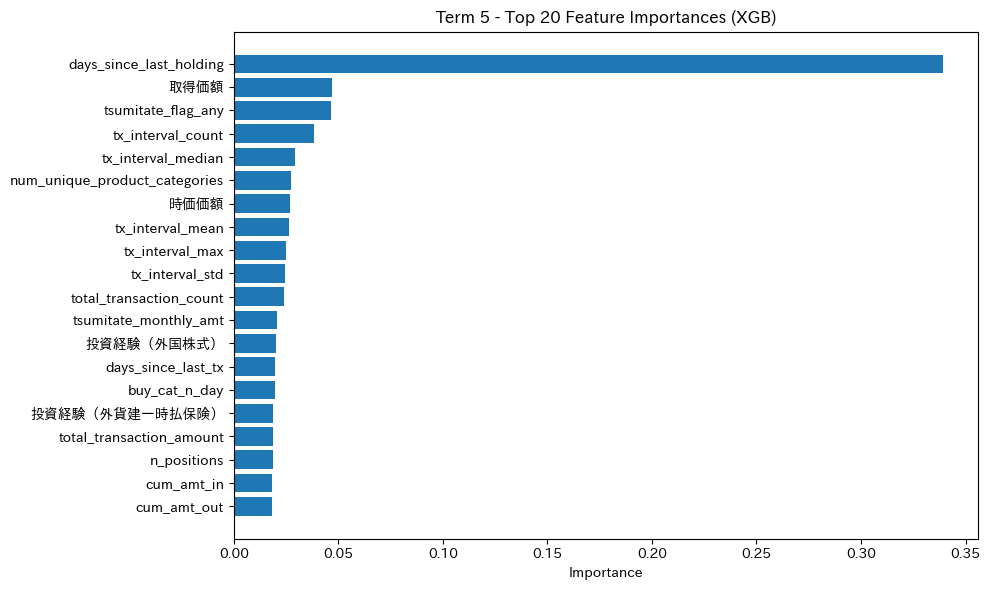


===== Term 6 の特徴量重要度 =====

Term 6 - Top 20 重要な特徴量:


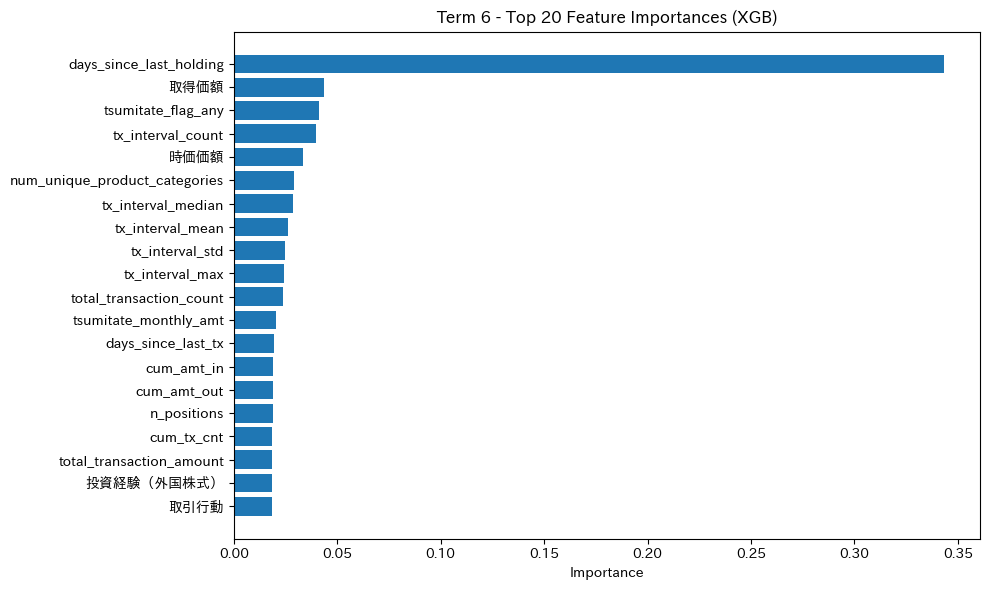


===== 全期間を通じた特徴量重要度の集計 =====

全期間平均 - Top 30 重要な特徴量:
                                   mean       std  count
feature                                                 
days_since_last_holding        0.341162  0.010556      6
取得価額                           0.044635  0.005404      6
tsumitate_flag_any             0.042845  0.004496      6
tx_interval_count              0.038820  0.000723      6
時価価額                           0.029927  0.005016      6
tx_interval_median             0.029135  0.000673      6
num_unique_product_categories  0.027326  0.000895      6
tx_interval_mean               0.025671  0.000803      6
total_transaction_count        0.024671  0.001058      6
tx_interval_std                0.024455  0.000452      6
tx_interval_max                0.024264  0.000623      6
tsumitate_monthly_amt          0.020557  0.000206      6
days_since_last_tx             0.019635  0.000496      6
n_positions                    0.019184  0.000422      6
buy_cat_n_day                  0.0

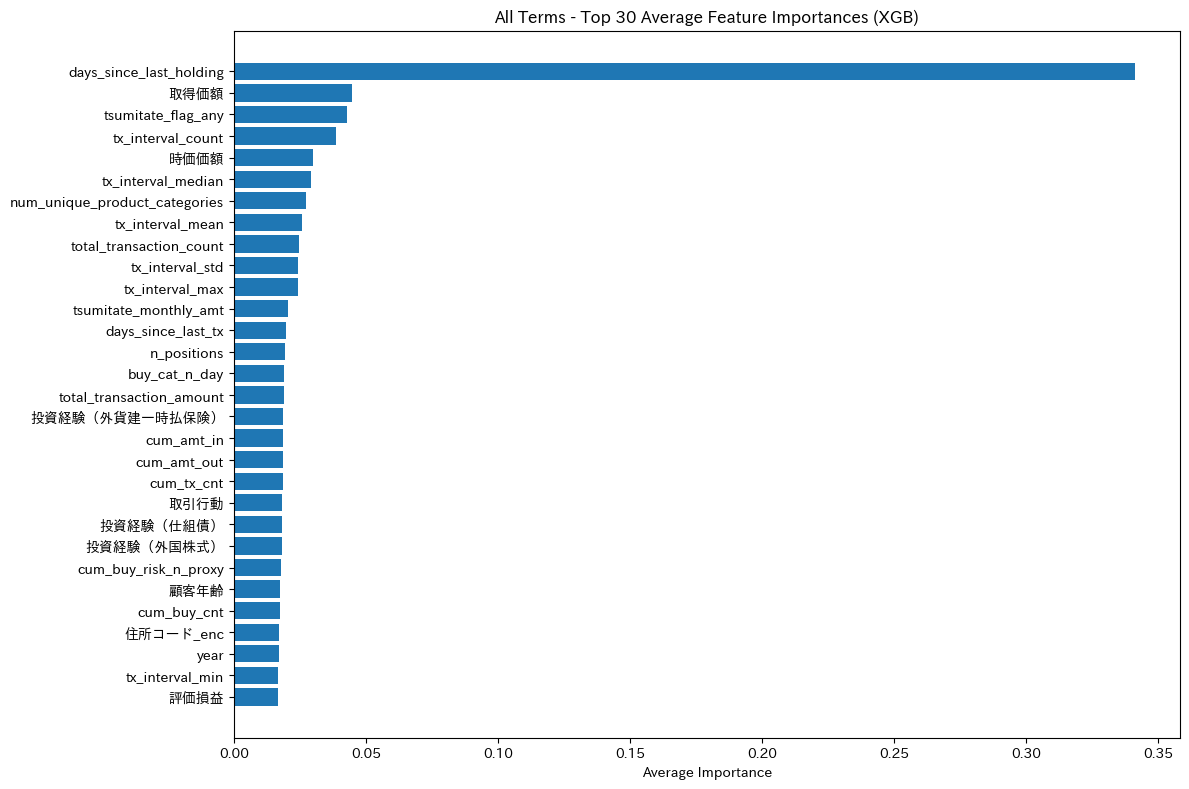

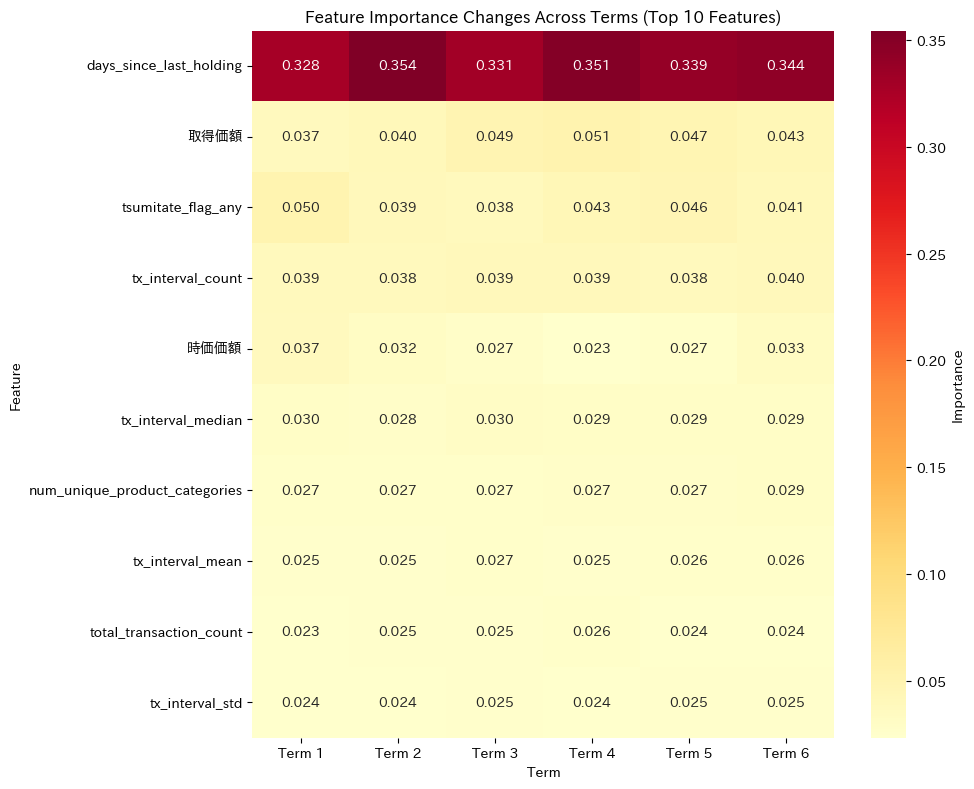

In [224]:
# 重要度を格納する辞書
feature_importances_dict = {}

# 各期間のモデルから重要度を取得
for i in range(1, 7):
    model = models[f'model_{i}']
    feature_names = feature_names_by_term[i]

    print(f"\n===== Term {i} の特徴量重要度 =====")

    # モデル種別に応じた重要度の取得
    if MODEL_KIND == 'laml':
        # 重要度の取得
        importances = model.get_feature_scores()
        feature_names = importances['Feature'].values
        importances = importances['Importance'].values

    elif MODEL_KIND in ['rf', 'lgbm', 'xgb']: # ここに'xgb'を追加
        # Random ForestやLightGBM, XGBoostの場合
        importances = model.feature_importances_

    elif MODEL_KIND == 'lr':
        # ロジスティック回帰の場合は係数の絶対値を重要度とする
        importances = np.abs(model.coef_[0])
    elif MODEL_KIND == 'dt':
        # ツリー構造の可視化
        plt.figure(figsize=(20, 10))
        plot_tree(model,
                  feature_names=feature_names,
                  class_names=['Class 0', 'Class 1'],  # クラス名は適宜変更してください
                  filled=True,
                  rounded=True,
                  fontsize=10,
                  max_depth=3)  # 表示する深さを制限（全体が見やすくなります）
        plt.title(f'Term {i} - Decision Tree Structure (max_depth=3 for visualization)')
        plt.tight_layout()
        plt.show()
        continue

    else:
        print(f"Term {i}: {MODEL_KIND}は重要度取得ができません")
        continue

    # 重要度とフィーチャー名を結合してDataFrame化
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # 辞書に保存
    feature_importances_dict[f'term_{i}'] = importance_df

    # 上位20個の重要な特徴量を表示
    print(f"\nTerm {i} - Top 20 重要な特徴量:")
    #print(importance_df.head(20).to_string(index=False))

    # 可視化（上位20個）
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(20)

    plt.barh(range(len(top_features)), top_features['importance'].values)
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Importance')
    plt.title(f'Term {i} - Top 20 Feature Importances ({MODEL_KIND.upper()})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ===== 全期間を通じた重要度の集計 =====
if feature_importances_dict:
    print("\n===== 全期間を通じた特徴量重要度の集計 =====")

    # 全期間の重要度を結合
    all_importances = []
    for term, df in feature_importances_dict.items():
        df_copy = df.copy()
        df_copy['term'] = term
        all_importances.append(df_copy)

    all_importances_df = pd.concat(all_importances, ignore_index=True)

    # 特徴量ごとの平均重要度を計算
    avg_importance = all_importances_df.groupby('feature')['importance'].agg([
        'mean', 'std', 'count'
    ]).sort_values('mean', ascending=False)

    print("\n全期間平均 - Top 30 重要な特徴量:")
    print(avg_importance.head(30).to_string())

    # 全期間平均の可視化
    plt.figure(figsize=(12, 8))
    top_avg_features = avg_importance.head(30)

    plt.barh(range(len(top_avg_features)), top_avg_features['mean'].values)
    plt.yticks(range(len(top_avg_features)), top_avg_features.index)
    plt.xlabel('Average Importance')
    plt.title(f'All Terms - Top 30 Average Feature Importances ({MODEL_KIND.upper()})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # ===== 期間ごとの重要度の変化を可視化（上位10特徴量） =====
    # 全期間平均で上位10の特徴量を選択
    top10_features = avg_importance.head(10).index.tolist()

    # ヒートマップ用のデータ準備
    heatmap_data = pd.DataFrame()
    for i in range(1, 7):
        if f'term_{i}' in feature_importances_dict:
            term_df = feature_importances_dict[f'term_{i}']
            term_importance = term_df.set_index('feature')['importance']

            # 上位10特徴量の重要度を取得（存在しない場合は0）
            term_values = []
            for feat in top10_features:
                if feat in term_importance.index:
                    term_values.append(term_importance[feat])
                else:
                    term_values.append(0)

            heatmap_data[f'Term {i}'] = term_values

    if not heatmap_data.empty:
        heatmap_data.index = top10_features

        # ヒートマップで可視化
        plt.figure(figsize=(10, 8))
        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                    cbar_kws={'label': 'Importance'})
        plt.title('Feature Importance Changes Across Terms (Top 10 Features)')
        plt.xlabel('Term')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

評価データに対する予測を行います。
分類問題では、`.predict()`で0か1かを直接予測する他に、`.predict_proba()`で各クラスに属する「確率」を予測することができます。今回のコンペティションでは、取引が発生する確率を提出するため、後者を使用します。

In [225]:
# ===== 推論（test）＋ 予測結合 =====
# 全期間の予測結果を格納するDataFrameを初期化
y_pred_df = pd.DataFrame()

# 6つの期間（term）ごとに推論を実行
for i in range(1, 7):
    # 現在の期間用のテストデータを取得
    X_test = X_test_dfs[f'X_test_{i}'].copy()

    # 学習時の特徴量列に合わせる（モデルが期待する列構成と一致させる）
    # 学習時に使用した特徴量名を取得
    cols = feature_names_by_term[i]
    # テストデータの列を学習時と同じにする（欠落列は0で埋め、列順も揃える）
    X_test = X_test.reindex(columns=cols, fill_value=0)

    # 該当期間の学習済みモデルを取得
    model = models[f'model_{i}']

    # ===== モデル種別に応じた予測処理 =====
    if MODEL_KIND == 'laml':
        # LAMLの場合の予測処理
        preds = model.predict(X_test)
        # LightAutoMLの出力から陽性確率を1次元配列として取得
        y_pred = preds.data.ravel()
    else:
        # その他のモデル（LR, RF, LGBM等）の場合
        # predict_probaでクラス1（陽性）の確率を取得
        y_pred = model.predict_proba(X_test)[:, 1]

    # ===== 予測結果とIDの紐付け =====
    # 現在の期間に該当するテストデータのIDを取得
    ids_i = test_df.loc[test_df[f'test_term_{i}'] == 1, 'ID'].reset_index(drop=True)

    # IDと予測確率をDataFrameにまとめる
    y_pred_i = pd.DataFrame({
        'ID': ids_i,
        'predict': pd.Series(y_pred).reset_index(drop=True)
    })

    # ===== 全期間の予測結果を結合 =====
    # 初回はそのまま代入、2回目以降は縦方向に結合
    y_pred_df = y_pred_i if y_pred_df.empty else pd.concat([y_pred_df, y_pred_i], ignore_index=True)

# 完了メッセージを表示
print("全てのtermに対する予測と結合が完了しました。")

全てのtermに対する予測と結合が完了しました。


今回のPoCでは予測期間1-6の内、予測期間1-3については学習データにそれぞれ正解データが含まれている状態.
→つまり、予測期間1-3は予測結果と正解データを使って予測精度をスコアとして確認ができる.
  
ここでは精度検証用にroc-aucを算出して確認する.


※全区間を同じコンセプトでモデル作成するのであれば、クロスバリデーション等の代わりになることもある

In [226]:
# 期間ごとのAUCスコアを格納する辞書を初期化
auc_by_term = {}

# 使用したモデル種別を表示
print(MODEL_KIND)

# ===== 予測結果に正解ラベルを付与 =====
# IDをキーとして、予測結果に訓練データの正解ラベル(y)を結合
y_with_true = y_pred_df.merge(train_df[['ID', 'y']], on='ID', how='left')

# ===== 期間1〜3のAUCを計算（評価用） =====
for i in [1, 2, 3]:
    # 現在の期間に該当するテストデータのIDを取得
    ids_i = set(test_df.loc[test_df[f'test_term_{i}'] == 1, 'ID'])

    # ===== 評価対象データの抽出 =====
    # 1. 現在の期間のIDに該当する行を抽出
    # 2. 正解ラベル(y)が存在する行のみに限定（NaNを除外）
    df_i = y_with_true[y_with_true['ID'].isin(ids_i)].dropna(subset=['y']).copy()

    # ===== データ不足のチェック =====
    # 対象行が0件の場合
    if df_i.shape[0] == 0:
        print(f"[term {i}] 対象行が0件のためスキップ")
        auc_by_term[f'term_{i}'] = np.nan
        continue

    # 正解ラベルが単一クラスの場合（全て0または全て1）
    # ROC-AUCは2クラス分類の評価指標のため計算不可
    if df_i['y'].nunique() < 2:
        print(f"[term {i}] 正解が単一クラスのためROC-AUC算出不可（陽性率={df_i['y'].mean():.4f}）")
        auc_by_term[f'term_{i}'] = np.nan
        continue

    # ===== ROC-AUCスコアの計算 =====
    # 正解ラベルと予測確率からAUCを計算
    auc = roc_auc_score(
        df_i['y'].astype(int),           # 正解ラベル（0 or 1）
        df_i['predict'].astype(float)     # 予測確率（0〜1の連続値）
    )

    # 結果を辞書に保存
    auc_by_term[f'term_{i}'] = auc

    # 結果を表示（データ件数と陽性率も併記）
    print(f"[term {i}] ROC-AUC = {auc:.4f}  (n={len(df_i)}, pos_rate={df_i['y'].mean():.4f})")

xgb
[term 1] ROC-AUC = 0.6693  (n=1000, pos_rate=0.2190)
[term 2] ROC-AUC = 0.6905  (n=1000, pos_rate=0.2120)
[term 3] ROC-AUC = 0.6956  (n=1000, pos_rate=0.2280)


<a name="5"></a>
# 第5章：提出用ファイルの作成

第4章では、AIモデルを構築・学習させ、評価データに対する予測確率 (`y_pred_df`) を得ることができました。
この最終章では、この予測結果をコンペティションの指定する形式に合わせてCSVファイルとして出力し、提出できる状態にします。


主なステップは以下の通りです。

1.  **提出用サンプルファイルの確認**: `sample_submit.csv` を改めて確認し、提出すべきファイルの列構成やIDの対応を把握します。
2.  **予測結果の整形**: 予測確率 `y_pred_df` を、提出用ファイルの形式に合わせて整形します。
3.  **CSVファイルへの出力**: 整形したデータをCSVファイルとして保存します。


## 5-1. 提出用サンプルファイルの確認

まず、提出用ファイルのフォーマットを確認するために、第2章で読み込んだ`submission_df`（`sample_submit.csv`）の内容を再度見てみましょう。

## 5-2. 予測結果の整形と提出用データフレームの作成

第4章で得られた予測結果 `y_pred_df` は、`X_test` の各行に対応する予測確率の配列です。この `y_pred_df` の `predict` 列を、`submission_df` の `1` 列に代入します。

In [227]:
# 提出用データフレームを作成
# submission_dfの右端のカラムに予測値を代入する。
submission_df[1] = y_pred_df['predict']
submission_df

,0,1
0,830001,0.000180
1,830002,0.000062
2,830003,0.230033
3,830004,0.099396
4,830005,0.090287
...,...,...
5995,930996,0.109110
5996,930997,0.173466
5997,930998,0.122168
5998,930999,0.169279


* これで、1列目に`ID`、2列目にモデルによる予測確率が格納された、提出形式のデータフレームが完成しました。


## 5-3. 提出用CSVファイルの出力

最後に、予測結果が格納された `submission_df` データフレームをCSVファイルとして保存します。
`pandas` の DataFrame には `.to_csv()` というメソッドがあり、これを使うと簡単にCSVファイルに出力できます。

* `index=False`: DataFrameのインデックス（行番号）をCSVファイルに出力しないように指定します。
* `header=False`: DataFrameのヘッダー（列名）をCSVファイルに出力しないように指定します。

これらの指定は、コンペティションの提出形式に合わせるために重要です。

※参考教材へのリンク... [to_csv()関数の使い方](https://biz.quest.signate.jp/quests/10010/contents/2/4/1)

In [228]:
# 提出用ファイル名
submission_file_name = 'my_submission_custom.csv' # ファイル名をここで変更

# 提出用データフレームをCSVファイルとして出力
# header=False とし、列名をファイルに含めない
# index=False とし、DataFrameのインデックスはファイルに含めない
submission_df.to_csv(base_dir + submission_file_name, index=False, header=False)

print(f"\n提出用ファイル '{submission_file_name}' が作成されました。")
print("このファイルをコンペティションサイトに提出してください。")


提出用ファイル 'my_submission_custom.csv' が作成されました。
このファイルをコンペティションサイトに提出してください。


<a name="6"></a>
# 第6章：精度改善に向けたヒント

機械学習のプロジェクトでは、一度モデルを作って終わりではなく、様々な工夫を重ねて性能を改善していくことが一般的です。

## 6-1. 特徴量エンジニアリング (Feature Engineering)

予測モデルの精度に大きく影響するのが、「特徴量」の質と量です。特徴量エンジニアリングとは、元のデータからモデルの学習に役立つ新しい特徴量を作り出す作業のことです。

* **他のデータソースの活用**:
    * 今回のサンプルコードでは、主に`train.csv`と`assessment_df`を使用しましたが、配布データには`約定データ一覧表.csv`や`月次保有明細`といった、より詳細な取引データや資産データが含まれています。これらのデータを結合し、新たな特徴量を作成することで、精度が向上する可能性があります。
    * 「購入取引と売却取引に関連があるのはどんなデータなのか」を考え、予測の手がかりになりそうなデータを説明変数Xとして追加してみましょう。
    * 例えば、顧客の過去のyの実績値など、「購入取引・売却取引の実績値が多い顧客は他の顧客と比べてyの発生確率が高くなるのではないか」という仮説を立てたとします。この仮説が正しい場合は、「顧客毎の、予測時点よりも過去のyの件数または発生率」という情報が、予測精度の向上に寄与するかもしれません。
* **時間に関連する特徴量の追加**:
    * **顧客の取引期間**: 初めて適合性判定シートを提出してからの経過期間。
    * **直近の取引からの経過時間**: 最後に取引（購入・売却）してからどのくらい時間が経っているか。
* **資産状況に関する特徴量の作成**:
    * **総資産額の推移**: 基準年月ごとの時価価額の増減率や、過去数ヶ月の平均資産額。
    * **ポートフォリオの変化**: 保有している商品の種類やリスク特性の変化。
* **顧客行動に関する特徴量**:
    * **過去の取引頻度**: これまでの購入・売却の回数。
    * **投資方針の変化**: 過去に投資方針を変更したことがあるか。

## 6-2. 異なるモデルの試行

今回は基本的な `DecisionTreeClassifier` を使用しましたが、他にも様々な機械学習モデルが存在します。問題の性質やデータの特性によっては、他のモデルの方が高い精度を示すことがあります。

どのモデルが「良い」「悪い」ということはなく、データの性質とモデルの特性の組み合わせによって最適解は異なります。

* **ロジスティック回帰 (`LogisticRegression`)**:
    * 分類問題における基本的なモデルの一つで、結果の解釈がしやすいという利点があります。まずはベースラインとして試す価値があります。
* **アンサンブル学習モデル**:
    * **ランダムフォレスト (`RandomForestClassifier`)**: 複数の決定木を組み合わせて、単体の決定木よりも安定した高い性能（過学習しにくい）を目指すモデルです。
    * **勾配ブースティング (`GradientBoostingClassifier`, `XGBoost`, `LightGBM`)**: 決定木を順番に学習させ、前のモデルの誤りを次のモデルが修正していく仕組みの非常に強力なモデル群です。多くのデータ分析コンペティションで高い性能を発揮しています。

※ 参考教材へのリンク... [scikit-learn道場](https://biz.quest.signate.jp/quests/10076)

## 6-3. ハイパーパラメータのチューニング

多くの機械学習モデルには、「ハイパーパラメータ」と呼ばれる、学習前に人間が設定する必要のあるパラメータがあります。これらの設定値によってモデルの性能が大きく変わることがあります。

* 例えば、`DecisionTreeClassifier` であれば、木の深さ (`max_depth`) や、分岐に必要な最小サンプル数 (`min_samples_split`) などがハイパーパラメータにあたります。
* `GridSearchCV` や `RandomizedSearchCV` (いずれも `scikit-learn` で提供) といったツールを使うと、複数のハイパーパラメータの組み合わせを効率的に試し、最適な設定を見つけることができます。

## 6-4. データのさらなる前処理・クレンジング

* **外れ値の処理**: 極端に大きな値や小さな値（外れ値）がモデルの学習に悪影響を与えることがあります。外れ値を除去したり、別の値に置き換えたり（例: 丸め込む）することを検討します。
* **欠損値の高度な補完**: 単純に0や平均値で埋めるのではなく、他の特徴量との関係から予測して補完する、あるいは統計的な値（中央値、最頻値）で補完するなど、より洗練された方法を試します。


## 6-5. モデル評価と改善サイクルの確立

* **モデル評価と改善の試行錯誤**: これまでの演習で、モデルの評価尺度を事前に決めたはずです（AUC）。その指標に基づいてモデルの性能を客観的に計測し、特徴量の追加やモデルの変更の効果を評価します。
* **交差検証 (Cross-Validation)**: 学習データを複数のグループに分割し、そのうちの1つを「検証用データ」、残りを「学習用データ」としてモデルを学習・評価する手法です。なお、今回は時系列データですので、分割の仕方に注意が必要です。

今回のコンペでは予測期間が6つありますが、これは時間的な順序を考慮した交差検証をコンペサイトを通じて行っているととらえることができます。  

ご自身で学習データを分割し交差検証を行う場合には、時系列データの取り扱いに注意し、検証用データよりも未来のデータを学習・評価に使うことにならないようにご注意ください。分割したデータを用いてモデルを学習・評価し、得られた評価スコア（AUC）の平均値やばらつきを確認することで、モデルの汎化性能をより現実的に見積もることができます。（コンペサイトに表示されるスコアよりも詳細な情報を手に入れることができ、モデルの改善に役立ちます）

これらの改善策を一つずつ、あるいは組み合わせて試し、評価指標がどのように変化するかを確認しながら、試行錯誤を繰り返していくことが精度向上の鍵となります。

これらのヒントを参考に、ぜひさらなる精度向上に挑戦してみてください。データ分析とモデル構築は、探求と発見の連続であり、非常に奥深い分野です。

## 参考教材

SIGNATE Cloudでは、予測課題に関する様々なケーススタディ教材を提供しています。<br>
以下に、当課題に取り組む上で参考になるであろう教材をピックアップしました。<br>
どれもマナビDXQuestの受講期間中は無料で受講できる教材となっておりますので、余裕のある方はお取り組みください。

- [金融機関におけるテレマーケティングの効率化](https://biz.quest.signate.jp/quests/10005)
    - 定期預金キャンペーンに対する顧客の申込率（反応率）を予測するモデルの作成に挑戦します。
- [健康経営のための疾患リスク軽減](https://biz.quest.signate.jp/quests/10012)
    - 従業員の健康管理を目的として、血液検査データをもとに個々人の疾患リスクを予測するモデルの作成に挑戦します。
- [債務不履行リスクの低減](https://biz.quest.signate.jp/quests/10009)
    - 負債者のデータを利用し、貸し倒れする負債者のパターンを精度高く予測するモデルの作成に挑戦します。
- [株価を予測せよ](https://biz.quest.signate.jp/quests/10008)
    - 未来の株価を予測する課題です。時系列情報を持った分類問題という点で当課題と共通しています。
    - Deep Learning技術を用いていることもあり、やや中上級者向けであることにご注意ください

### 特徴量エンジニアリングのアイデア例

以下のデータソースから、顧客ごとの集計や時系列的な変化を捉える特徴量を作成することを検討できます。

**約定データ一覧表.csv から**

*   **取引回数・頻度**:
    *   過去〇ヶ月間の総取引回数、購入回数、売却回数
    *   直近の取引からの経過日数
    *   月平均の取引回数
*   **取引金額**:
    *   過去〇ヶ月間の総購入金額、総売却金額
    *   平均購入金額、平均売却金額
    *   累積購入金額、累積売却金額
*   **取引商品の多様性**:
    *   過去〇ヶ月間に取引した異なる商品カテゴリやリスクカテゴリの数
*   **取引行動の傾向**:
    *   損益確定（売却・償還）の頻度や金額
    *   オンライン取引の割合
    *   ゴール設定やロスカット設定の有無・頻度

**月次保有明細 から**

*   **資産状況**:
    *   時価総額の過去〇ヶ月間の平均、中央値、最大値、最小値
    *   評価損益の平均、合計、およびその変動
    *   ポートフォリオにおける評価損益率（評価損益 / 取得価額）の分布や平均
    *   通貨別（JPY, USD, AUDなど）の資産構成比率や金額
*   **ポートフォリオの構造**:
    *   保有ポジション数（保有銘柄数）の推移
    *   積立投資の有無、月額、および継続期間
    *   保有商品のリスクカテゴリや商品カテゴリの多様性
*   **資産の変動性**:
    *   時価総額や評価損益の過去〇ヶ月間の標準偏差や変動係数（標準偏差 / 平均）

**顧客属性データ（assessment_df）と組み合わせて**

*   **投資経験と取引行動の関連**:
    *   特定の投資経験がある顧客の取引頻度や取引金額の傾向
*   **顧客年齢と資産状況の関連**:
    *   年齢層ごとの平均資産額やポートフォリオの特性

これらの特徴量を、特定の期間（例: 過去3ヶ月、過去6ヶ月、過去12ヶ月など）で集計することで、顧客の最新の行動や資産状況を捉えることができます。また、累積値（例: 累積取引回数、累積購入金額）も有効な特徴量となり得ます。